# Integrating Deep Learning Time-Series Models into Predictive Maintenance Frameworks

In [1]:
# Import required libraries
import pandas as maintenance_pd
import numpy as maintenance_np
import seaborn as maintenance_sns
from sklearn.preprocessing import MinMaxScaler as Maintenance_MinMaxScaler
from sklearn.model_selection import train_test_split as Maintenance_train_test_split
from sklearn.ensemble import RandomForestClassifier as Maintenance_RandomForestClassifier
from sklearn.linear_model import LogisticRegression as Maintenance_LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE as Maintenance_SMOTE
import xgboost as maintenance_xgb
from tensorflow.keras.models import Sequential as Maintenance_Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense as Maintenance_Dense, Dropout as Maintenance_Dropout
from tensorflow.keras.optimizers import Adam as Maintenance_Adam
from tensorflow.keras.callbacks import EarlyStopping as Maintenance_EarlyStopping
from sklearn.model_selection import GridSearchCV as Maintenance_GridSearchCV
from tensorflow.keras import Input
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os
from sklearn.preprocessing import MinMaxScaler as Maintenance_MinMaxScaler

from scipy.stats import kurtosis, skew

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Load the Dataset
print("Loading AI4I 2020 Predictive Maintenance Dataset...")
maintenance_data = maintenance_pd.read_csv("predictive_maintenance.csv")

Loading AI4I 2020 Predictive Maintenance Dataset...


In [3]:
# Examine dataset structure and dimensions
print("Dataset dimensions (rows x columns):", maintenance_data.shape)
print("\nInitial data preview:")
print(maintenance_data.head())

Dataset dimensions (rows x columns): (10000, 10)

Initial data preview:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  


In [4]:
# Analyze dataset characteristics and statistical properties
print("Dataset structure and data types:")
print(maintenance_data.info())
print("\nStatistical overview of numerical features:")
print(maintenance_data.describe())

Dataset structure and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None

Statistical overview of numerical features:
               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         1

In [5]:
# Identify missing data patterns
print("Missing value assessment:")
print(maintenance_data.isnull().sum())

# Clean dataset by removing incomplete records
maintenance_data.dropna(inplace=True)
print(f"Updated dataset dimensions after cleaning: {maintenance_data.shape}")

Missing value assessment:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64
Updated dataset dimensions after cleaning: (10000, 10)


In [6]:
# Detect duplicate entries in the dataset
maintenance_duplicate_check = maintenance_data.duplicated().any()
print(f"Presence of duplicate records: {maintenance_duplicate_check}")

# Eliminate duplicate records if found
if maintenance_duplicate_check:
    maintenance_data.drop_duplicates(inplace=True)
print(f"Final dataset size after deduplication: {maintenance_data.shape}")

Presence of duplicate records: False
Final dataset size after deduplication: (10000, 10)


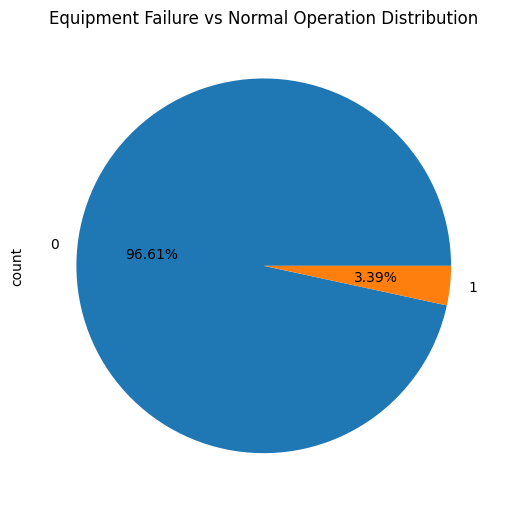

In [7]:
plt.figure(figsize=(15, 10))

# Pie chart for failure distribution
plt.subplot(2, 3, 1)
maintenance_data['Target'].value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.title('Equipment Failure vs Normal Operation Distribution')
plt.tight_layout()
plt.show()

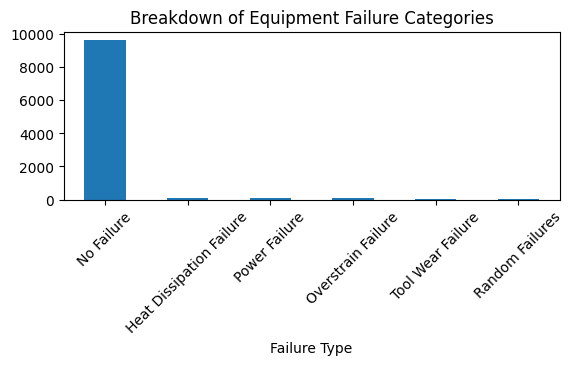

In [8]:
# Display failure type breakdown
if 'Failure Type' in maintenance_data.columns:
    plt.subplot(2, 1, 2)
    maintenance_data['Failure Type'].value_counts().plot(kind='bar')
    plt.title('Breakdown of Equipment Failure Categories')
    plt.xticks(rotation=45)


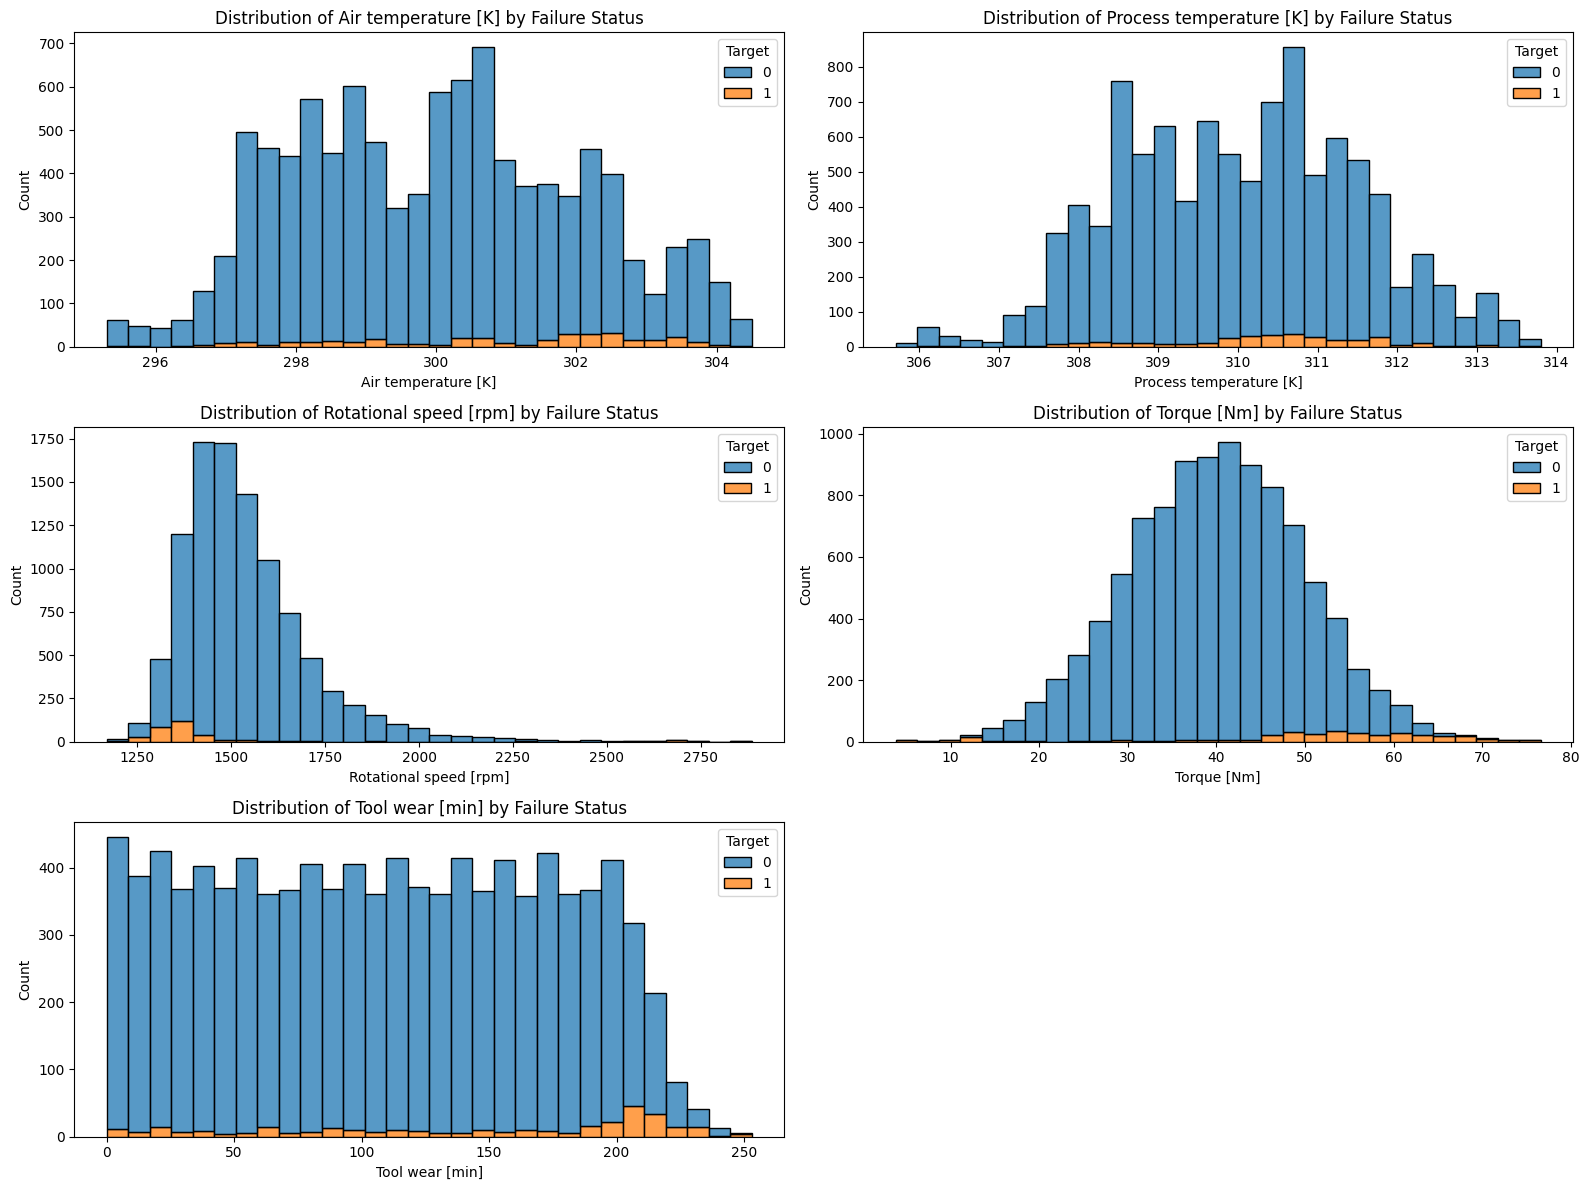

In [9]:
# Sensor data analysis and visualization
plt.figure(figsize=(16, 12))
sensor_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Distribution plots for each sensor by failure status
for i, feature in enumerate(sensor_features, 1):
    plt.subplot(3, 2, i)
    maintenance_sns.histplot(data=maintenance_data, x=feature, hue='Target', multiple="stack", bins=30)
    plt.title(f'Distribution of {feature} by Failure Status')
plt.tight_layout()
plt.show()

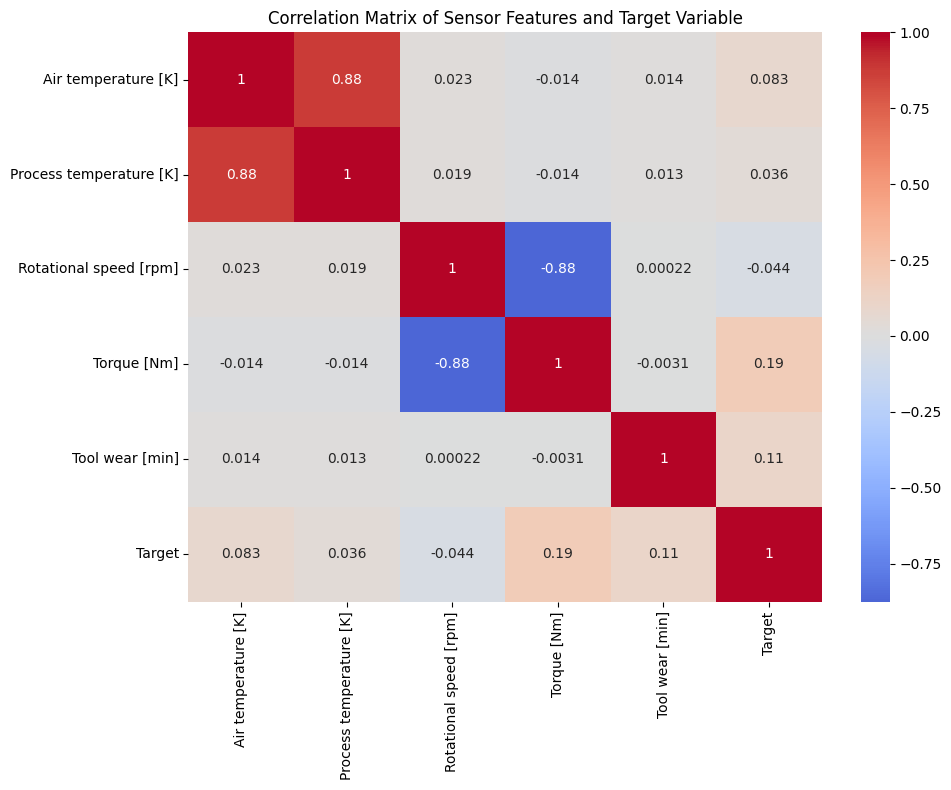

In [10]:
# Correlation analysis between sensor variables
plt.figure(figsize=(10, 8))
correlation_features = sensor_features + ['Target']
maintenance_sns.heatmap(maintenance_data[correlation_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Sensor Features and Target Variable')
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

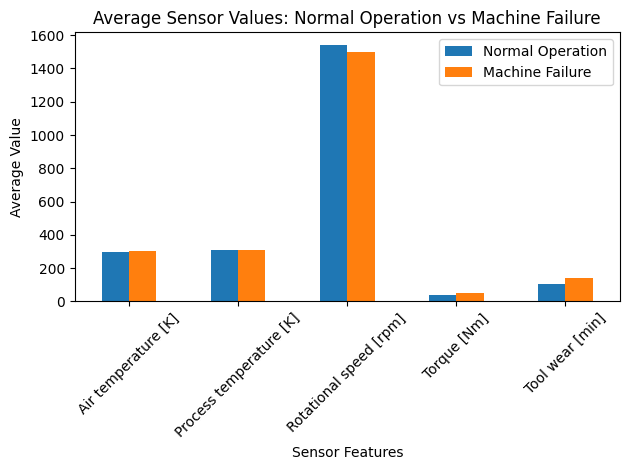

In [11]:
# Average sensor values comparison between normal and failure cases
plt.figure(figsize=(14, 6))
feature_means_by_target = maintenance_data.groupby('Target')[sensor_features].mean()
feature_means_by_target.T.plot(kind='bar')
plt.title('Average Sensor Values: Normal Operation vs Machine Failure')
plt.xlabel('Sensor Features')
plt.ylabel('Average Value')
plt.legend(['Normal Operation', 'Machine Failure'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
# Class imbalance examination
print("\n=== CLASS IMBALANCE ANALYSIS ===")
target_counts = maintenance_data['Target'].value_counts()
print("Target variable distribution:")
print(f"Normal Operation (0): {target_counts[0]} samples ({target_counts[0]/len(maintenance_data)*100:.2f}%)")
print(f"Machine Failure (1): {target_counts[1]} samples ({target_counts[1]/len(maintenance_data)*100:.2f}%)")
print(f"Imbalance ratio: {target_counts[0]/target_counts[1]:.2f}:1")



=== CLASS IMBALANCE ANALYSIS ===
Target variable distribution:
Normal Operation (0): 9661 samples (96.61%)
Machine Failure (1): 339 samples (3.39%)
Imbalance ratio: 28.50:1


In [13]:
# Feature selection and engineering for modeling
print("\n=== FEATURE ENGINEERING AND PREPROCESSING ===")

# Select relevant features for machine learning model
modeling_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Encode categorical product type variable
maintenance_data['Type_encoded'] = maintenance_data['Type'].map({'L': 0, 'M': 1, 'H': 2})
modeling_features.append('Type_encoded')

# Create feature matrix and target vector
X_features = maintenance_data[modeling_features]
y_target = maintenance_data['Target']

print("Selected features for predictive modeling:")
for idx, feature in enumerate(modeling_features, 1):
    print(f"{idx}. {feature}")


=== FEATURE ENGINEERING AND PREPROCESSING ===
Selected features for predictive modeling:
1. Air temperature [K]
2. Process temperature [K]
3. Rotational speed [rpm]
4. Torque [Nm]
5. Tool wear [min]
6. Type_encoded


In [14]:
# Feature scaling using Min-Max normalization
maintenance_scaler = Maintenance_MinMaxScaler(feature_range=(0, 1))
X_scaled_features = maintenance_scaler.fit_transform(X_features)
X_scaled_features = maintenance_pd.DataFrame(X_scaled_features, columns=modeling_features)

# Clean and rename feature names to remove special characters for XGBoost compatibility
X_scaled_features.columns = X_scaled_features.columns.str.replace('[\[\]<>]', '', regex=True).str.replace(' ', '_')

# Update modeling_features list to reflect renamed columns
modeling_features = X_scaled_features.columns.tolist()

print("\nFeature scaling completed using Min-Max normalization")
print("Scaled feature summary statistics:")
print(X_scaled_features.describe().round(4))

# Dataset splitting for training and testing
X_train_set, X_test_set, y_train_set, y_test_set = Maintenance_train_test_split(
    X_scaled_features, y_target, test_size=0.2, random_state=5702, stratify=y_target
)

print(f"\nDataset partitioning results:")
print(f"Training set dimensions: {X_train_set.shape}")
print(f"Testing set dimensions: {X_test_set.shape}")
print(f"Training target distribution: {y_train_set.value_counts().sort_index().values}")
print(f"Testing target distribution: {y_test_set.value_counts().sort_index().values}")



Feature scaling completed using Min-Max normalization
Scaled feature summary statistics:
       Air_temperature_K  Process_temperature_K  Rotational_speed_rpm  \
count         10000.0000             10000.0000            10000.0000   
mean              0.5114                 0.5316                0.2158   
std               0.2174                 0.1832                0.1044   
min               0.0000                 0.0000                0.0000   
25%               0.3261                 0.3827                0.1484   
50%               0.5217                 0.5432                0.1950   
75%               0.6739                 0.6667                0.2584   
max               1.0000                 1.0000                1.0000   

        Torque_Nm  Tool_wear_min  Type_encoded  
count  10000.0000     10000.0000    10000.0000  
mean       0.4971         0.4267        0.2502  
std        0.1369         0.2516        0.3357  
min        0.0000         0.0000        0.0000  
25%    

<>:7: SyntaxWarning: invalid escape sequence '\['
<>:7: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-378877156.py:7: SyntaxWarning: invalid escape sequence '\['
  X_scaled_features.columns = X_scaled_features.columns.str.replace('[\[\]<>]', '', regex=True).str.replace(' ', '_')


In [15]:
# SMOTE application for addressing class imbalance
print("\n=== SMOTE IMPLEMENTATION FOR CLASS BALANCING ===")
maintenance_smote = Maintenance_SMOTE(random_state=5702, sampling_strategy='auto')
X_train_balanced, y_train_balanced = maintenance_smote.fit_resample(X_train_set, y_train_set)

print("SMOTE balancing results:")
print(f"Original training set shape: {X_train_set.shape}")
print(f"Balanced training set shape: {X_train_balanced.shape}")
print(f"Original class distribution: {y_train_set.value_counts().sort_index().values}")
print(f"Balanced class distribution: {y_train_balanced.value_counts().sort_index().values}")



=== SMOTE IMPLEMENTATION FOR CLASS BALANCING ===
SMOTE balancing results:
Original training set shape: (8000, 6)
Balanced training set shape: (15458, 6)
Original class distribution: [7729  271]
Balanced class distribution: [7729 7729]


In [16]:
# ================================
# Deep Learning Time-Series Extension: LSTM and GRU
# ================================

# Convert training data to synthetic sequential format for time-series modeling
time_steps = 5
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return maintenance_np.array(Xs), maintenance_np.array(ys)

X_seq, y_seq = create_sequences(X_scaled_features, y_target, time_steps)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = Maintenance_train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=5702, stratify=y_seq
)

print(f"LSTM/GRU input shape: {X_train_seq.shape}")

# --- Balance the sequential training data ---
from imblearn.over_sampling import SMOTE
X_seq_flat = X_train_seq.reshape((X_train_seq.shape[0], -1))
sm = SMOTE(random_state=5702)
X_seq_bal, y_seq_bal = sm.fit_resample(X_seq_flat, y_train_seq)
X_seq_bal = X_seq_bal.reshape((X_seq_bal.shape[0], time_steps, X_train_seq.shape[2]))
print("After SMOTE balancing:", X_seq_bal.shape, y_seq_bal.shape)

# Evaluation Function
def evaluate_model(model, X_test, y_test, name):
    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)
    prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

    print(f"\n{name} Results:")
    print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, ROC-AUC={roc_auc:.4f}, PR-AUC={pr_auc:.4f}")

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(recall, precision)
    plt.title(f'{name} - Precision-Recall Curve')

    plt.subplot(1,3,2)
    plt.plot(prob_pred, prob_true)
    plt.title(f'{name} - Calibration Plot')

    plt.subplot(1,3,3)
    plt.hist(y_pred_prob, bins=20)
    plt.title(f'{name} - Prediction Probability Distribution')

    plt.tight_layout()
    plt.show()

    # Return metrics for later use
    return acc, prec, rec, f1, roc_auc, pr_auc

LSTM/GRU input shape: (7996, 5, 6)
After SMOTE balancing: (15450, 5, 6) (15450,)


Deep Learning Model Development and Training

Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6441 - loss: 0.6351 - val_accuracy: 0.5764 - val_loss: 0.7698
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6993 - loss: 0.5632 - val_accuracy: 0.3220 - val_loss: 0.9775
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7279 - loss: 0.5411 - val_accuracy: 0.5178 - val_loss: 0.8705
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7550 - loss: 0.5138 - val_accuracy: 0.7417 - val_loss: 0.6694
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7701 - loss: 0.5050 - val_accuracy: 0.6288 - val_loss: 0.7721
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7776 - loss: 0.4932 - val_accuracy: 0.7294 - val_loss: 0.7128
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7794 - loss: 0.4930 - val_accuracy: 0.7479 - val_loss: 0.6842
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7883 - loss: 0.4799 - val_accuracy: 0

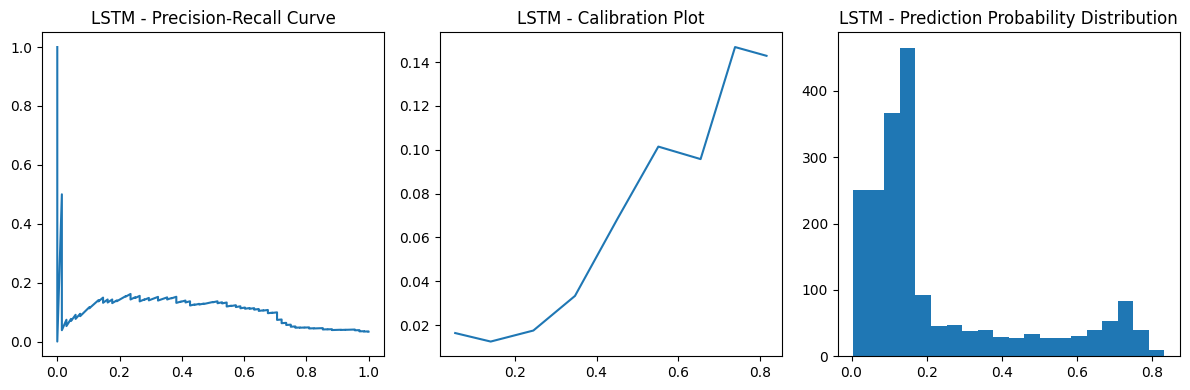

In [17]:
model_lstm = Maintenance_Sequential([
    Input(shape=(time_steps, X_train_seq.shape[2])),
    LSTM(64, return_sequences=True),
    Maintenance_Dropout(0.2),
    LSTM(32),
    Maintenance_Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_seq_bal, y_seq_bal, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_roc_auc, lstm_pr_auc = evaluate_model(model_lstm, X_test_seq, y_test_seq, "LSTM")

Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6352 - loss: 0.6321 - val_accuracy: 0.4557 - val_loss: 0.8502
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7091 - loss: 0.5564 - val_accuracy: 0.8236 - val_loss: 0.5523
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7441 - loss: 0.5255 - val_accuracy: 0.6074 - val_loss: 0.7668
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7620 - loss: 0.5177 - val_accuracy: 0.6686 - val_loss: 0.7515
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7698 - loss: 0.5093 - val_accuracy: 0.6460 - val_loss: 0.7941
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7699 - loss: 0.5065 - val_accuracy: 0.6485 - val_loss: 0.7838
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7879 - loss: 0.4772 - val_accuracy: 0.6971 - val_loss: 0.7493
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7907 - loss: 0.4750 - val_accuracy:

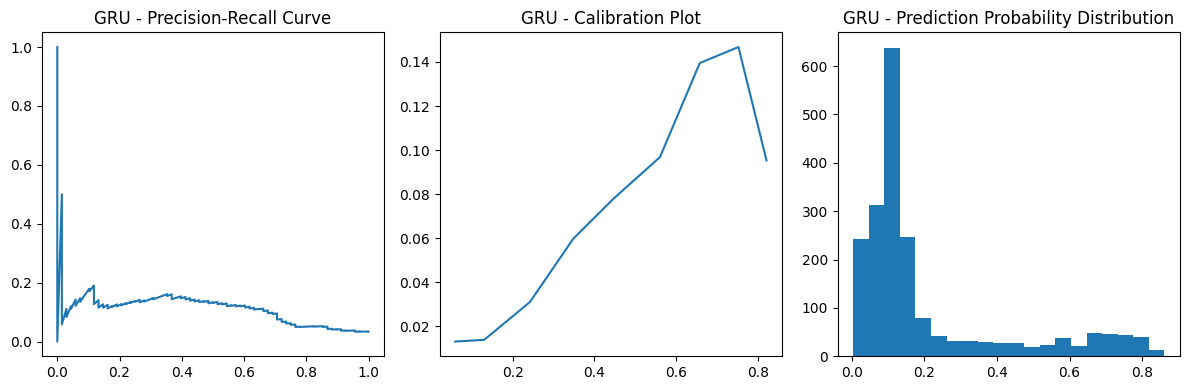

In [18]:
# ============ GRU MODEL ============
model_gru = Maintenance_Sequential([
    Input(shape=(time_steps, X_train_seq.shape[2])),
    GRU(64, return_sequences=True),
    Maintenance_Dropout(0.2),
    GRU(32),
    Maintenance_Dense(1, activation='sigmoid')
])
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gru.fit(X_seq_bal, y_seq_bal, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

gru_accuracy, gru_precision, gru_recall, gru_f1, gru_roc_auc, gru_pr_auc = evaluate_model(model_gru, X_test_seq, y_test_seq, "GRU")

Deep Learning Model Performance Metrics Comparison:
Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  PR-AUC
 LSTM    0.8474     0.1214  0.5588    0.1995   0.7425  0.1033
  GRU    0.8629     0.1295  0.5294    0.2081   0.7489  0.1081


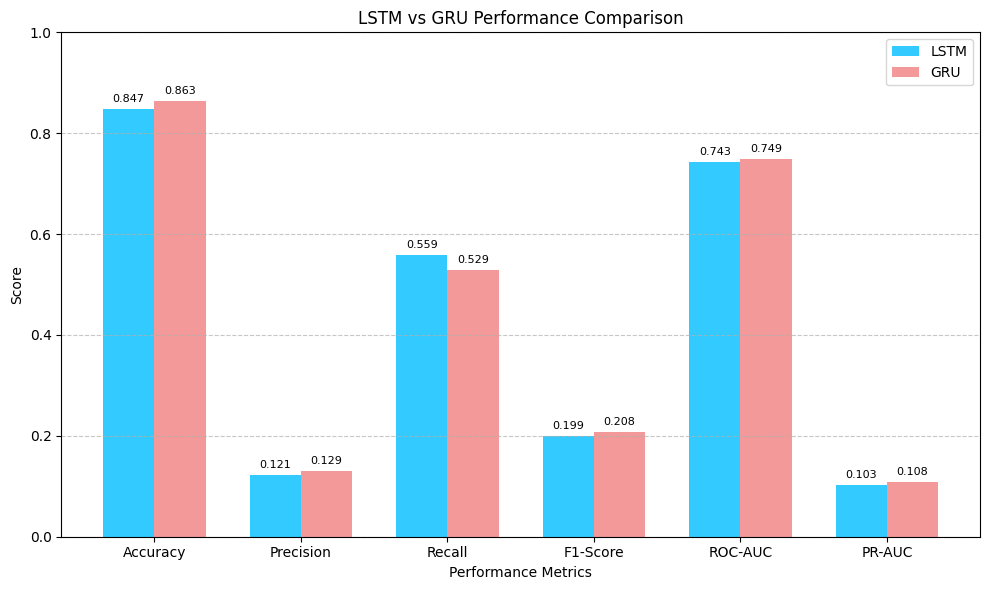

In [19]:
# ================================
# Performance Comparison for Deep Learning Models Only (LSTM & GRU)
# ================================

# Create comparison dataframe dynamically from computed variables
performance_comparison_dl = {
    'Model': ['LSTM', 'GRU'],
    'Accuracy': [lstm_accuracy, gru_accuracy],
    'Precision': [lstm_precision, gru_precision],
    'Recall': [lstm_recall, gru_recall],
    'F1-Score': [lstm_f1, gru_f1],
    'ROC-AUC': [lstm_roc_auc, gru_roc_auc],
    'PR-AUC': [lstm_pr_auc, gru_pr_auc]
}

performance_df_dl = maintenance_pd.DataFrame(performance_comparison_dl)
print("Deep Learning Model Performance Metrics Comparison:")
print(performance_df_dl.round(4).to_string(index=False))

# Visualization
plt.figure(figsize=(10, 6))
metrics_for_visualization = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
bar_width = 0.35
index_positions = maintenance_np.arange(len(metrics_for_visualization))

model_names = ['LSTM', 'GRU']
color_palette = ['deepskyblue', 'lightcoral']

for i, model in enumerate(model_names):
    metric_values = [performance_comparison_dl[metric][i] for metric in metrics_for_visualization]
    plt.bar(index_positions + i * bar_width, metric_values, bar_width,
           label=model, alpha=0.8, color=color_palette[i])

plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('LSTM vs GRU Performance Comparison')
plt.xticks(index_positions + bar_width / 2, metrics_for_visualization)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.0)

# Add value labels
for i, model in enumerate(model_names):
    metric_values = [performance_comparison_dl[metric][i] for metric in metrics_for_visualization]
    for j, value in enumerate(metric_values):
        plt.text(j + i * bar_width, value + 0.01, f'{value:.3f}',
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


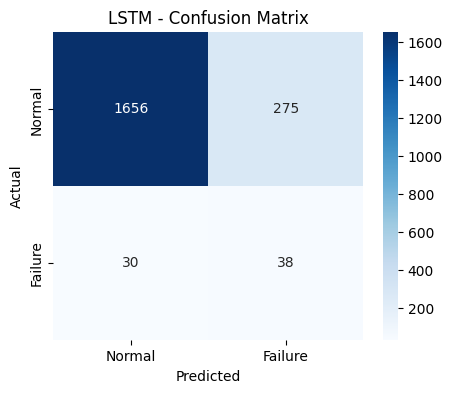

LSTM Confusion Matrix:
True Negatives: 1656, False Positives: 275
False Negatives: 30, True Positives: 38

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


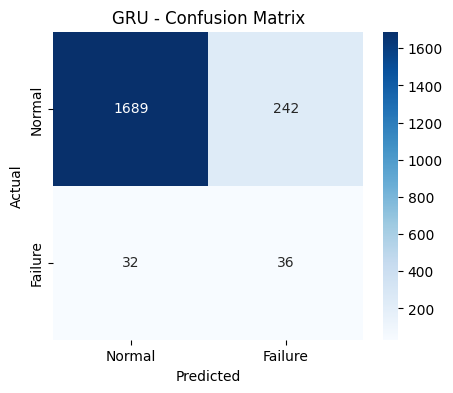

GRU Confusion Matrix:
True Negatives: 1689, False Positives: 242
False Negatives: 32, True Positives: 36



In [20]:
# Confusion matrices for LSTM and GRU
def plot_confusion_matrix(model, X_test, y_test, name):
    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    maintenance_sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Failure'],
                yticklabels=['Normal', 'Failure'])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    print(f"{name} Confusion Matrix:")
    print(f"True Negatives: {tn}, False Positives: {fp}")
    print(f"False Negatives: {fn}, True Positives: {tp}\n")

# Plot confusion matrices
plot_confusion_matrix(model_lstm, X_test_seq, y_test_seq, "LSTM")
plot_confusion_matrix(model_gru, X_test_seq, y_test_seq, "GRU")


### CMAPSSData

In [21]:
def maintenance_load_cmapss_dataset(base_path, fd_list=['FD001', 'FD002', 'FD003', 'FD004']):
    all_train, all_test = [], []

    for fd in fd_list:
        train_file = os.path.join(base_path, f"train_{fd}.txt")
        test_file = os.path.join(base_path, f"test_{fd}.txt")
        rul_file = os.path.join(base_path, f"RUL_{fd}.txt")

        # Load train, test, and RUL files
        train_df = maintenance_pd.read_csv(train_file, sep=r'\s+', header=None)
        test_df = maintenance_pd.read_csv(test_file, sep=r'\s+', header=None)
        rul_df = maintenance_pd.read_csv(rul_file, sep=r'\s+', header=None)

        # Clean empty columns
        train_df.dropna(axis=1, how='all', inplace=True)
        test_df.dropna(axis=1, how='all', inplace=True)

        # Define column names
        cols = ['unit', 'cycle'] + [f'setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, train_df.shape[1] - 4)]
        train_df.columns = cols
        test_df.columns = cols

        # Compute Remaining Useful Life (RUL)
        rul_train = train_df.groupby('unit')['cycle'].max().reset_index()
        rul_train.columns = ['unit', 'max_cycle']
        train_df = train_df.merge(rul_train, on='unit', how='left')
        train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
        train_df.drop('max_cycle', axis=1, inplace=True)

        rul_test = test_df.groupby('unit')['cycle'].max().reset_index()
        rul_test.columns = ['unit', 'max_cycle']
        test_df = test_df.merge(rul_test, on='unit', how='left')
        test_df['RUL'] = test_df['max_cycle'] - test_df['cycle']
        test_df.drop('max_cycle', axis=1, inplace=True)

        # --- Clip RUL values (Standard NASA practice) ---
        max_rul = 125
        train_df['RUL'] = train_df['RUL'].clip(upper=max_rul)
        test_df['RUL'] = test_df['RUL'].clip(upper=max_rul)

       # --- Normalize per engine unit ---
        scaler = Maintenance_MinMaxScaler()
        scaled_train, scaled_test = [], []

        for uid in train_df['unit'].unique():
            sub = train_df[train_df['unit'] == uid].copy()
            sub.iloc[:, 2:-1] = scaler.fit_transform(sub.iloc[:, 2:-1])
            scaled_train.append(sub)
        train_df = maintenance_pd.concat(scaled_train, ignore_index=True)

        for uid in test_df['unit'].unique():
            sub = test_df[test_df['unit'] == uid].copy()
            sub.iloc[:, 2:-1] = scaler.fit_transform(sub.iloc[:, 2:-1])
            scaled_test.append(sub)
        test_df = maintenance_pd.concat(scaled_test, ignore_index=True)

        all_train.append(train_df)
        all_test.append(test_df)

    combined_train = maintenance_pd.concat(all_train, ignore_index=True)
    combined_test = maintenance_pd.concat(all_test, ignore_index=True)
    print("Combined CMAPSS Data Loaded:", combined_train.shape, combined_test.shape)
    return combined_train, combined_test

In [22]:
# Load all CMAPSS subdatasets
base_cmapss_path = "CMAPSSData"
train_data, test_data = maintenance_load_cmapss_dataset(base_cmapss_path)


Combined CMAPSS Data Loaded: (160359, 27) (104897, 27)



NASA C-MAPSS DATASET - EXPLORATORY DATA ANALYSIS

1. Dataset Statistics:
   Training records: 160359
   Test records: 104897
   Number of engines (train): 260
   Number of engines (test): 259
   Features: 27

2. RUL Statistics:
count    160359.000000
mean         90.182029
std          41.241036
min           0.000000
25%          56.000000
50%         113.000000
75%         125.000000
max         125.000000
Name: RUL, dtype: float64


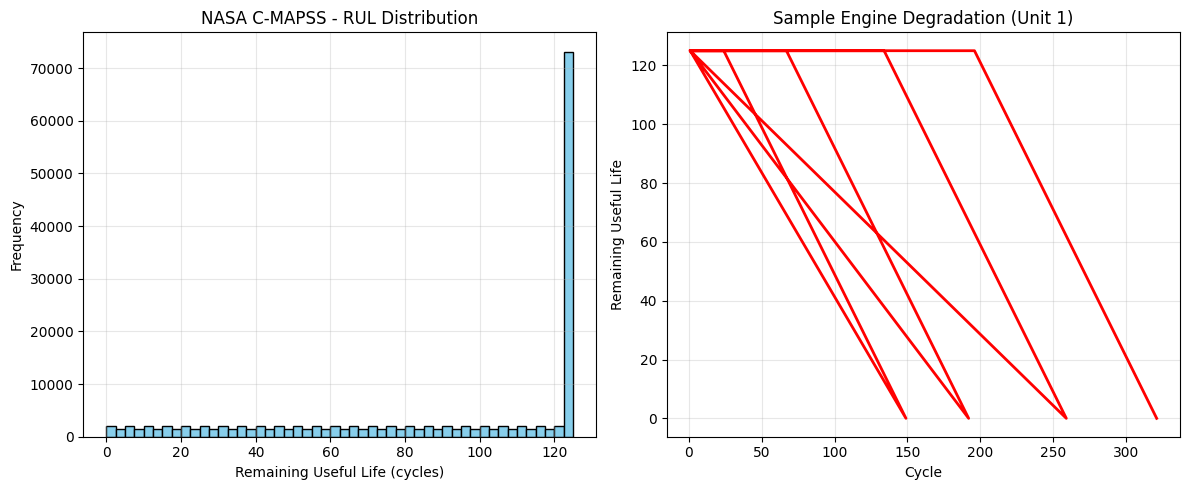

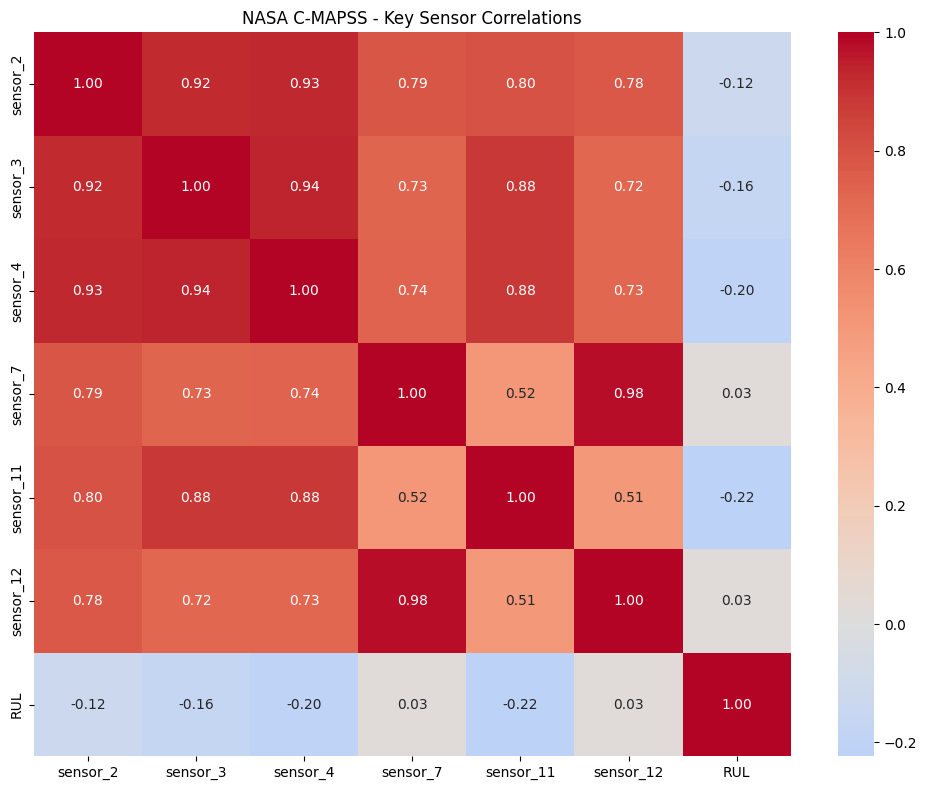

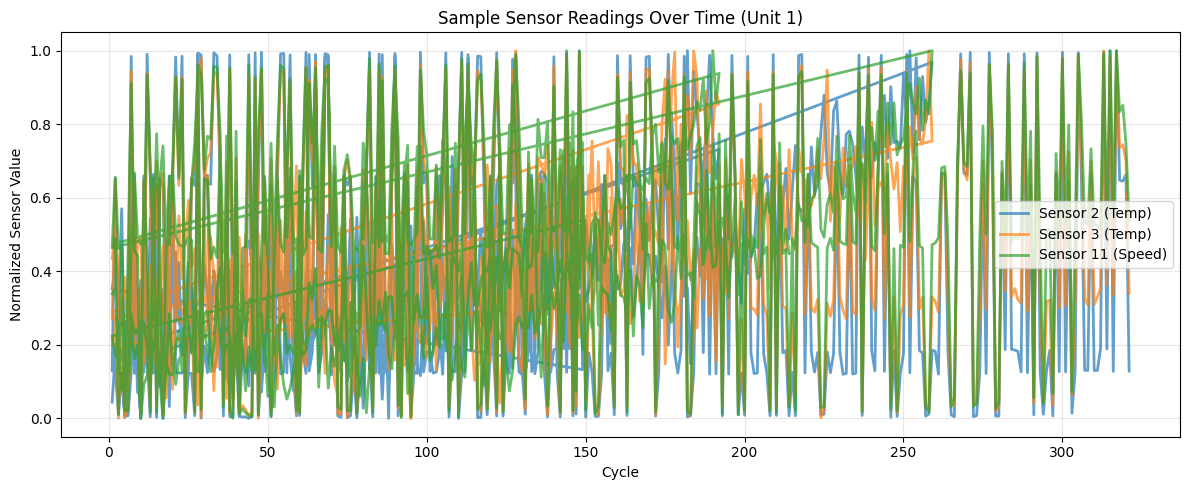


 NASA C-MAPSS EDA completed


In [23]:
# ================================
# NASA C-MAPSS - EDA
# ================================

print("\n" + "="*80)
print("NASA C-MAPSS DATASET - EXPLORATORY DATA ANALYSIS")
print("="*80)

# Basic statistics
print(f"\n1. Dataset Statistics:")
print(f"   Training records: {len(train_data)}")
print(f"   Test records: {len(test_data)}")
print(f"   Number of engines (train): {train_data['unit'].nunique()}")
print(f"   Number of engines (test): {test_data['unit'].nunique()}")
print(f"   Features: {train_data.shape[1]}")

# RUL distribution
print(f"\n2. RUL Statistics:")
print(train_data['RUL'].describe())

# Plot 1: RUL distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(train_data['RUL'], bins=50, edgecolor='black', color='skyblue')
plt.xlabel('Remaining Useful Life (cycles)')
plt.ylabel('Frequency')
plt.title('NASA C-MAPSS - RUL Distribution')
plt.grid(True, alpha=0.3)

# Plot 2: Sample engine degradation
plt.subplot(1, 2, 2)
sample_engine = train_data[train_data['unit'] == 1]
plt.plot(sample_engine['cycle'], sample_engine['RUL'], linewidth=2, color='red')
plt.xlabel('Cycle')
plt.ylabel('Remaining Useful Life')
plt.title('Sample Engine Degradation (Unit 1)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 3: Sensor correlations
plt.figure(figsize=(10, 8))
selected_sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_11', 'sensor_12', 'RUL']
corr_matrix = train_data[selected_sensors].corr()
maintenance_sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('NASA C-MAPSS - Key Sensor Correlations')
plt.tight_layout()
plt.show()

# Plot 4: Sensor behavior over time
plt.figure(figsize=(12, 5))
plt.plot(sample_engine['cycle'], sample_engine['sensor_2'], label='Sensor 2 (Temp)', linewidth=2, alpha=0.7)
plt.plot(sample_engine['cycle'], sample_engine['sensor_3'], label='Sensor 3 (Temp)', linewidth=2, alpha=0.7)
plt.plot(sample_engine['cycle'], sample_engine['sensor_11'], label='Sensor 11 (Speed)', linewidth=2, alpha=0.7)
plt.xlabel('Cycle')
plt.ylabel('Normalized Sensor Value')
plt.title('Sample Sensor Readings Over Time (Unit 1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n NASA C-MAPSS EDA completed")

In [24]:
# --- Sequence creation ---
def maintenance_create_sequences(df, time_steps=30):
    Xs, ys = [], []
    feature_cols = df.columns[2:-1]
    for unit_id in df['unit'].unique():
        unit_data = df[df['unit'] == unit_id]
        X_unit = unit_data[feature_cols].values
        y_unit = unit_data['RUL'].values
        for i in range(len(X_unit) - time_steps):
            Xs.append(X_unit[i:i+time_steps])
            ys.append(y_unit[i+time_steps])
    return maintenance_np.array(Xs), maintenance_np.array(ys)

time_steps = 30
X_train_cmapss, y_train_cmapss = maintenance_create_sequences(train_data, time_steps)
X_test_cmapss, y_test_cmapss = maintenance_create_sequences(test_data, time_steps)
print("Final Sequence Shapes:", X_train_cmapss.shape, X_test_cmapss.shape)

Final Sequence Shapes: (152559, 30, 24) (97127, 30, 24)


In [25]:
# --- Model builder ---
def maintenance_build_rul_model(model_type='LSTM', time_steps=30, features=None):
    features = features or X_train_cmapss.shape[2]
    model = Maintenance_Sequential([
        Input(shape=(time_steps, features)),
        (LSTM if model_type == 'LSTM' else GRU)(64, return_sequences=True),
        Maintenance_Dropout(0.2),
        (LSTM if model_type == 'LSTM' else GRU)(32),
        Maintenance_Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [26]:
# --- Train LSTM ---
model_lstm = maintenance_build_rul_model('LSTM', time_steps, X_train_cmapss.shape[2])
history_lstm = model_lstm.fit(X_train_cmapss, y_train_cmapss, validation_split=0.2, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 6562.9102 - mae: 71.2180 - val_loss: 2524.5923 - val_mae: 44.9670
Epoch 2/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 2258.1179 - mae: 43.1396 - val_loss: 1748.4080 - val_mae: 37.3237
Epoch 3/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1724.6296 - mae: 37.0736 - val_loss: 1756.0601 - val_mae: 36.7238
Epoch 4/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1712.8824 - mae: 36.5720 - val_loss: 1754.8068 - val_mae: 36.7474
Epoch 5/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1564.9161 - mae: 34.5206 - val_loss: 905.8468 - val_mae: 24.5581
Epoch 6/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 541.9416 - mae: 17.5222 - val_loss: 567.8058 - val_mae: 17.7933
Epoch 7/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 416.0666 - mae: 14.2273 - val_loss: 484.1972 - val_mae: 14.9633
Epoch 8/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 346.1695 - mae: 12.6382 - val_loss: 430

In [27]:
model_lstm.save_weights("/content/lstm_cmapss_pretrained.weights.h5")

In [28]:
# --- Train GRU ---
model_gru = maintenance_build_rul_model('GRU', time_steps, X_train_cmapss.shape[2])
history_gru = model_gru.fit(X_train_cmapss, y_train_cmapss, validation_split=0.2, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 6446.9126 - mae: 70.4810 - val_loss: 2491.7166 - val_mae: 44.7192
Epoch 2/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 2239.4114 - mae: 43.0296 - val_loss: 1748.3168 - val_mae: 37.3182
Epoch 3/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1719.5902 - mae: 37.0218 - val_loss: 1753.1044 - val_mae: 36.7853
Epoch 4/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1714.0792 - mae: 36.6200 - val_loss: 1754.1017 - val_mae: 36.7626
Epoch 5/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 1716.9901 - mae: 36.6697 - val_loss: 1754.2729 - val_mae: 36.7587
Epoch 6/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1501.1544 - mae: 33.3193 - val_loss: 1098.4077 - val_mae: 27.8569
Epoch 7/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 605.2102 - mae: 18.7239 - val_loss: 533.3002 - val_mae: 16.8523
Epoch 8/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 372.8903 - mae: 13.3637 - val_loss: 

In [29]:
model_gru.save_weights("/content/gru_cmapss_pretrained.weights.h5")

3036/3036 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

LSTM Results:
RMSE=31.8855, MAE=24.1819, R²=0.4510


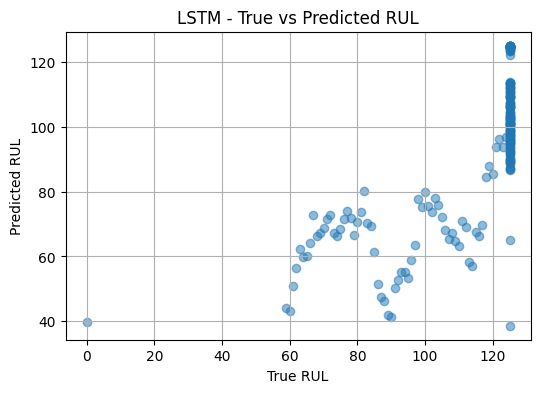

3036/3036 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

GRU Results:
RMSE=32.0235, MAE=24.2700, R²=0.4462


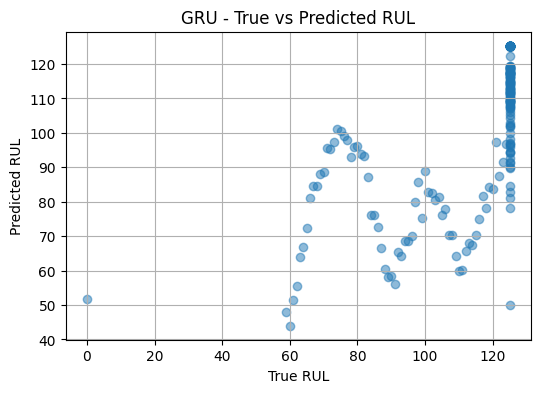

In [30]:
# --- Evaluation ---

from math import sqrt

def maintenance_evaluate_rul_model(model, X_test, y_test, name):
    preds = model.predict(X_test).ravel()
    rmse = sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"\n{name} Results:")
    print(f"RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
    plt.figure(figsize=(6,4))
    plt.scatter(y_test[:200], preds[:200], alpha=0.5)
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"{name} - True vs Predicted RUL")
    plt.grid(True)
    plt.show()
    return rmse, mae, r2

lstm_rmse, lstm_mae, lstm_r2 = maintenance_evaluate_rul_model(model_lstm, X_test_cmapss, y_test_cmapss, "LSTM")
gru_rmse, gru_mae, gru_r2 = maintenance_evaluate_rul_model(model_gru, X_test_cmapss, y_test_cmapss, "GRU")


=== CMAPSS Model Performance Summary ===
Model    RMSE     MAE     R²
 LSTM 31.8855 24.1819 0.4510
  GRU 32.0235 24.2700 0.4462


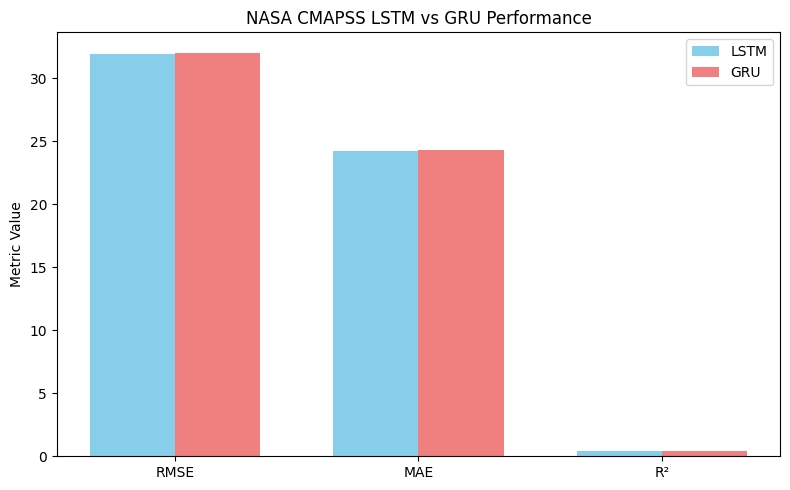

In [31]:
# --- Comparison summary ---
cmapss_summary = maintenance_pd.DataFrame({
    'Model': ['LSTM', 'GRU'],
    'RMSE': [lstm_rmse, gru_rmse],
    'MAE': [lstm_mae, gru_mae],
    'R²': [lstm_r2, gru_r2]
})
print("\n=== CMAPSS Model Performance Summary ===")
print(cmapss_summary.round(4).to_string(index=False))

plt.figure(figsize=(8,5))
x = maintenance_np.arange(3)
bar_width = 0.35
plt.bar(x, cmapss_summary.iloc[0,1:].values, width=bar_width, label='LSTM', color='skyblue')
plt.bar(x + bar_width, cmapss_summary.iloc[1,1:].values, width=bar_width, label='GRU', color='lightcoral')
plt.xticks(x + bar_width/2, ['RMSE','MAE','R²'])
plt.ylabel('Metric Value')
plt.title('NASA CMAPSS LSTM vs GRU Performance')
plt.legend()
plt.tight_layout()
plt.show()

### PHM2012 Bearing Dataset

In [40]:
#!apt-get install p7zip-full -y
!7z x /content/PHM2012Data.zip -o/content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 419665750 bytes (401 MiB)

Extracting archive: /content/PHM2012Data.zip
 17% 4096 Open              --
Path = /content/PHM2012Data.zip
Type = zip
Physical Size = 419665750

  0%      1% 230 - PHM2012Data/Learning_set/Bearing1_1/acc_00228.csv                                                              1% 417 - PHM2012Data/Learning_set/Bearing1_1/acc_00415.csv                                                            

In [39]:
# !rm -rf /content/PHM2012Data/

In [41]:
from scipy.stats import kurtosis, skew

def maintenance_load_phm_dataset(base_path='PHM2012Data'):
    records = []

    for dataset_type in ["Learning_set", "Test_set"]:
        dataset_dir = os.path.join(base_path, dataset_type)
        print(f"\nProcessing: {dataset_type}")

        for bearing_folder in sorted(os.listdir(dataset_dir)):
            bearing_path = os.path.join(dataset_dir, bearing_folder)
            if not os.path.isdir(bearing_path):
                continue

            acc_files = sorted([f for f in os.listdir(bearing_path) if f.endswith(".csv")])
            total_files = len(acc_files)

            if total_files == 0:
                continue

            print(f"  {bearing_folder}: {total_files} CSV files")

            # Last 20% of bearing life is considered failure
            failure_threshold = int(total_files * 0.8)

            for i, acc_file in enumerate(acc_files):
                file_path = os.path.join(bearing_path, acc_file)

                try:
                    # Read CSV with comma separator
                    df = maintenance_pd.read_csv(file_path, header=None)

                    # Columns: Hour, Minute, Second, Microsecond, Horiz_accel, Vert_accel
                    if df.shape[1] == 6:
                        df.columns = ["hour", "minute", "second", "microsecond", "acc_x", "acc_y"]

                        acc_x = df["acc_x"].values
                        acc_y = df["acc_y"].values

                        # Calculate statistical features
                        features = {
                            "mean_x": acc_x.mean(),
                            "std_x": acc_x.std(),
                            "max_x": acc_x.max(),
                            "min_x": acc_x.min(),
                            "kurt_x": kurtosis(acc_x),
                            "skew_x": skew(acc_x),
                            "rms_x": maintenance_np.sqrt((acc_x ** 2).mean()),

                            "mean_y": acc_y.mean(),
                            "std_y": acc_y.std(),
                            "max_y": acc_y.max(),
                            "min_y": acc_y.min(),
                            "kurt_y": kurtosis(acc_y),
                            "skew_y": skew(acc_y),
                            "rms_y": maintenance_np.sqrt((acc_y ** 2).mean()),

                            "total_rms": maintenance_np.sqrt((acc_x ** 2).mean() + (acc_y ** 2).mean()),
                            "peak_to_peak": (acc_x.max() - acc_x.min()) + (acc_y.max() - acc_y.min()),

                            "Target": 1 if i >= failure_threshold else 0,
                            "Bearing": bearing_folder,
                            "Source": dataset_type,
                            "FileIndex": i,
                            "TimeNormalized": i / total_files
                        }
                        records.append(features)

                except Exception as e:
                    print(f"    Warning: Could not process {acc_file}: {e}")
                    continue

    phm_df = maintenance_pd.DataFrame(records)
    print(f"\n Loaded PHM 2012 dataset: {phm_df.shape}")
    print(f"\nTarget distribution:")
    print(phm_df['Target'].value_counts())
    print(f"\nClass balance: {phm_df['Target'].value_counts(normalize=True).round(4)}")

    return phm_df

# Load PHM dataset
phm_data = maintenance_load_phm_dataset('PHM2012Data')

# Display summary
print("\n" + "="*80)
print("PHM DATASET SUMMARY")
print("="*80)
print(f"\nDataset shape: {phm_data.shape}")
print(f"Number of bearings: {phm_data['Bearing'].nunique()}")
print(f"Features: {phm_data.columns.tolist()}")
print(f"\nFirst few rows:")
print(phm_data.head())
print(f"\nBasic statistics:")
print(phm_data.describe())


Processing: Learning_set
  Bearing1_1: 3269 CSV files
  Bearing1_2: 1015 CSV files
  Bearing2_1: 1062 CSV files
  Bearing2_2: 797 CSV files
  Bearing3_1: 604 CSV files
  Bearing3_2: 1637 CSV files

Processing: Test_set
  Bearing1_3: 1802 CSV files
  Bearing1_4: 1327 CSV files
  Bearing1_5: 2685 CSV files
  Bearing1_6: 2685 CSV files
  Bearing1_7: 1752 CSV files
  Bearing2_3: 1202 CSV files
  Bearing2_4: 713 CSV files
  Bearing2_5: 2337 CSV files
  Bearing2_6: 572 CSV files
  Bearing2_7: 200 CSV files
  Bearing3_3: 410 CSV files

 Loaded PHM 2012 dataset: (21493, 21)

Target distribution:
Target
0    19249
1     2244
Name: count, dtype: int64

Class balance: Target
0    0.8956
1    0.1044
Name: proportion, dtype: float64

PHM DATASET SUMMARY

Dataset shape: (21493, 21)
Number of bearings: 17
Features: ['mean_x', 'std_x', 'max_x', 'min_x', 'kurt_x', 'skew_x', 'rms_x', 'mean_y', 'std_y', 'max_y', 'min_y', 'kurt_y', 'skew_y', 'rms_y', 'total_rms', 'peak_to_peak', 'Target', 'Bearing', 'Sou


IEEE PHM 2012 DATASET - EXPLORATORY DATA ANALYSIS

1. Dataset Statistics:
   Total records: 21493
   Number of bearings: 17
   Bearings: ['Bearing1_1', 'Bearing1_2', 'Bearing2_1', 'Bearing2_2', 'Bearing3_1', 'Bearing3_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7', 'Bearing3_3']
   Features: 21

2. Target Distribution:
Target
0    19249
1     2244
Name: count, dtype: int64
   Normal: 19249 (89.56%)
   Failure: 2244 (10.44%)

3. Vibration Feature Statistics:
             mean_x         std_x         rms_x        mean_y         std_y  \
count  21493.000000  21493.000000  21493.000000  21493.000000  21493.000000   
mean       0.001234      0.419241      0.419806      0.001478      0.464050   
std        0.020964      0.279462      0.279403      0.028812      0.281575   
min       -0.602544      0.036993      0.039270     -1.009009      0.063328   
25%       -0.008912      0.300131      0.30072

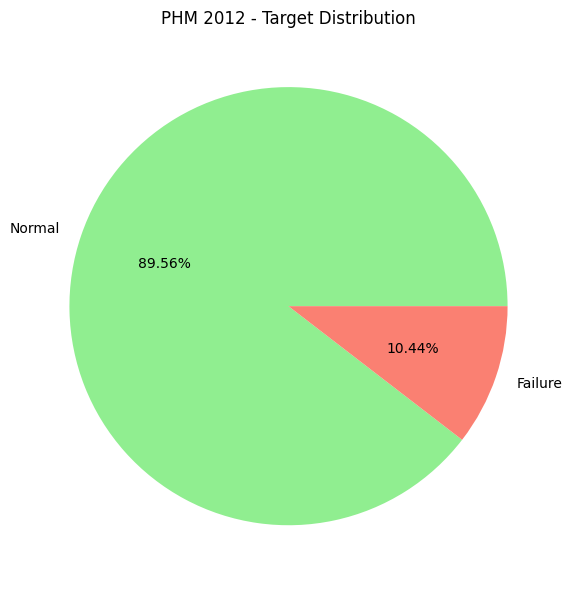

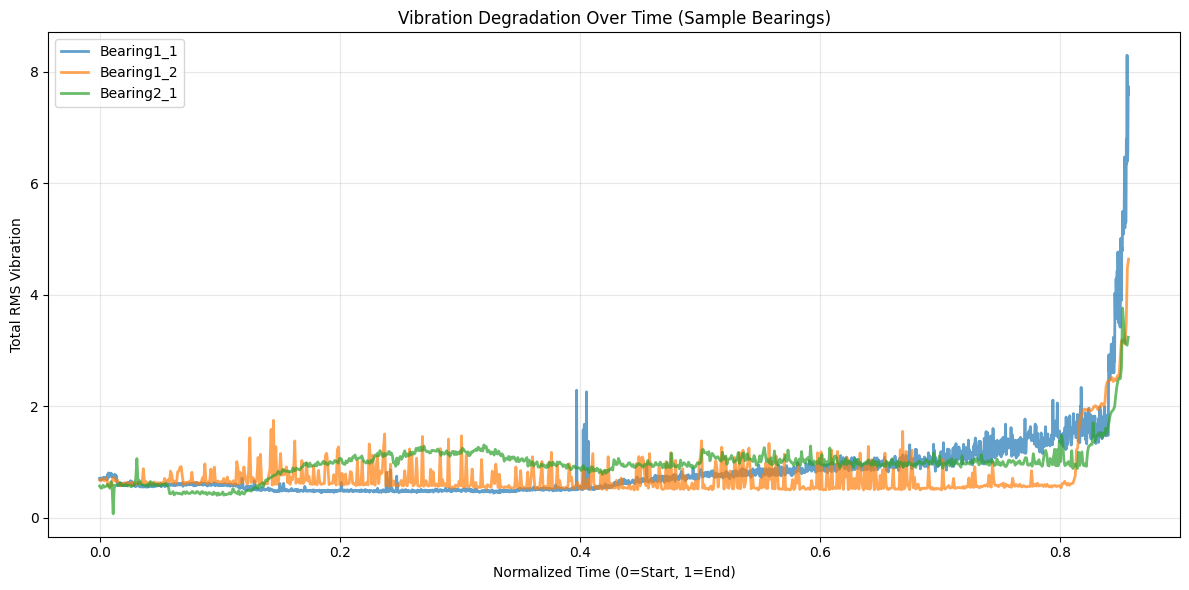

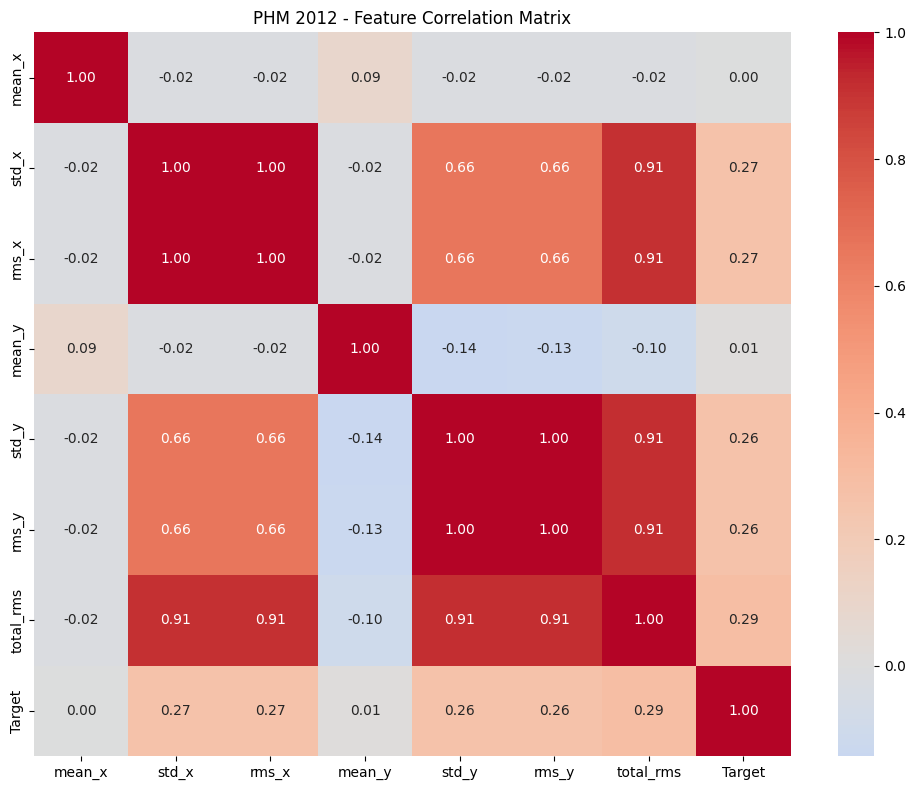

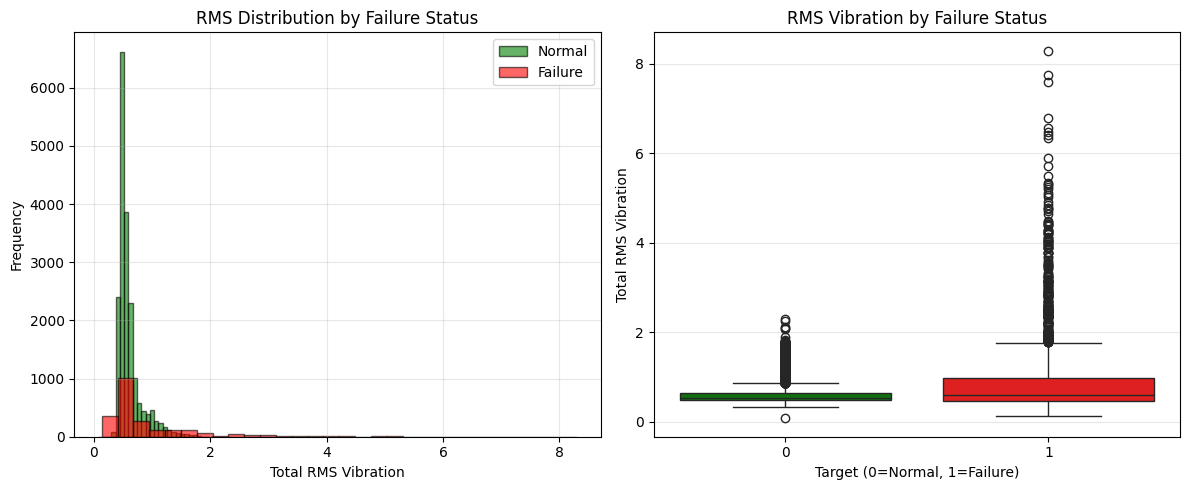


 PHM 2012 EDA completed


In [42]:
# ================================
# PHM 2012 - EDA
# ================================

print("\n" + "="*80)
print("IEEE PHM 2012 DATASET - EXPLORATORY DATA ANALYSIS")
print("="*80)

# Basic statistics
print(f"\n1. Dataset Statistics:")
print(f"   Total records: {len(phm_data)}")
print(f"   Number of bearings: {phm_data['Bearing'].nunique()}")
print(f"   Bearings: {list(phm_data['Bearing'].unique())}")
print(f"   Features: {phm_data.shape[1]}")

# Target distribution
print(f"\n2. Target Distribution:")
print(phm_data['Target'].value_counts())
print(f"   Normal: {(phm_data['Target']==0).sum()} ({(phm_data['Target']==0).sum()/len(phm_data)*100:.2f}%)")
print(f"   Failure: {(phm_data['Target']==1).sum()} ({(phm_data['Target']==1).sum()/len(phm_data)*100:.2f}%)")

# Feature statistics
print(f"\n3. Vibration Feature Statistics:")
print(phm_data[['mean_x', 'std_x', 'rms_x', 'mean_y', 'std_y', 'rms_y', 'total_rms']].describe())

# Plot 1: Target distribution
plt.figure(figsize=(8, 6))
phm_data['Target'].value_counts().plot(kind='pie', autopct='%1.2f%%',
                                        labels=['Normal', 'Failure'],
                                        colors=['lightgreen', 'salmon'])
plt.title('PHM 2012 - Target Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Plot 2: Vibration over time (sample bearings)
plt.figure(figsize=(12, 6))
for bearing in phm_data['Bearing'].unique()[:3]:  # Show first 3 bearings
    bearing_data = phm_data[phm_data['Bearing'] == bearing]
    plt.plot(bearing_data['TimeNormalized'], bearing_data['total_rms'],
             label=bearing, alpha=0.7, linewidth=2)
plt.xlabel('Normalized Time (0=Start, 1=End)')
plt.ylabel('Total RMS Vibration')
plt.title('Vibration Degradation Over Time (Sample Bearings)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Feature correlation
plt.figure(figsize=(10, 8))
phm_corr_features = ['mean_x', 'std_x', 'rms_x', 'mean_y', 'std_y', 'rms_y', 'total_rms', 'Target']
corr_phm = phm_data[phm_corr_features].corr()
maintenance_sns.heatmap(corr_phm, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('PHM 2012 - Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Plot 4: RMS distribution by failure status
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(phm_data[phm_data['Target']==0]['total_rms'], bins=30,
         alpha=0.6, label='Normal', color='green', edgecolor='black')
plt.hist(phm_data[phm_data['Target']==1]['total_rms'], bins=30,
         alpha=0.6, label='Failure', color='red', edgecolor='black')
plt.xlabel('Total RMS Vibration')
plt.ylabel('Frequency')
plt.title('RMS Distribution by Failure Status')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Box plot comparison
plt.subplot(1, 2, 2)
maintenance_sns.boxplot(data=phm_data, x='Target', y='total_rms', palette=['green', 'red'])
plt.xlabel('Target (0=Normal, 1=Failure)')
plt.ylabel('Total RMS Vibration')
plt.title('RMS Vibration by Failure Status')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n PHM 2012 EDA completed")

In [43]:
# ---------- Preprocessing ----------
features_phm = [c for c in phm_data.columns if c not in ["Target", "Bearing", "Source"]]
X_phm = phm_data[features_phm]
y_phm = phm_data["Target"]

scaler_phm = Maintenance_MinMaxScaler()
X_phm_scaled = maintenance_pd.DataFrame(scaler_phm.fit_transform(X_phm), columns=features_phm)

X_train_phm, X_test_phm, y_train_phm, y_test_phm = Maintenance_train_test_split(
    X_phm_scaled, y_phm, test_size=0.2, random_state=5702, stratify=y_phm
)

X_train_seq_phm = X_train_phm.values.reshape((X_train_phm.shape[0], 1, X_train_phm.shape[1]))
X_test_seq_phm = X_test_phm.values.reshape((X_test_phm.shape[0], 1, X_test_phm.shape[1]))


In [44]:
# ---------- Model Definition ----------
def maintenance_build_phm_model(model_type="LSTM", input_shape=(1, len(features_phm))):
    model = Maintenance_Sequential([
        Input(shape=input_shape),
        (LSTM if model_type == "LSTM" else GRU)(64, return_sequences=True),
        Maintenance_Dropout(0.2),
        (LSTM if model_type == "LSTM" else GRU)(32),
        Maintenance_Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [45]:
# ---------- Train Models ----------
print("\nTraining LSTM model...")
model_lstm_phm = maintenance_build_phm_model("LSTM", (1, X_train_seq_phm.shape[2]))
model_lstm_phm.fit(X_train_seq_phm, y_train_phm, validation_split=0.2, epochs=10, batch_size=64, verbose=1)


Training LSTM model...
Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8910 - loss: 0.4743 - val_accuracy: 0.9026 - val_loss: 0.2385
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9075 - loss: 0.2070 - val_accuracy: 0.9500 - val_loss: 0.1094
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9651 - loss: 0.0903 - val_accuracy: 0.9858 - val_loss: 0.0501
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9827 - loss: 0.0506 - val_accuracy: 0.9921 - val_loss: 0.0376
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9881 - loss: 0.0380 - val_accuracy: 0.9828 - val_loss: 0.0369
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9875 - loss: 0.0337 - val_accuracy: 0.9945 - val_loss: 0.0261
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9868 - loss: 0.0329 - val_accuracy: 0.9869 - val_loss: 0.0287
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9904 - loss: 

In [46]:
print("\nTraining GRU model...")
model_gru_phm = maintenance_build_phm_model("GRU", (1, X_train_seq_phm.shape[2]))
model_gru_phm.fit(X_train_seq_phm, y_train_phm, validation_split=0.2, epochs=10, batch_size=64, verbose=1)


Training GRU model...
Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8805 - loss: 0.4133 - val_accuracy: 0.9136 - val_loss: 0.1781
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9280 - loss: 0.1469 - val_accuracy: 0.9578 - val_loss: 0.0811
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9758 - loss: 0.0669 - val_accuracy: 0.9855 - val_loss: 0.0492
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9808 - loss: 0.0516 - val_accuracy: 0.9898 - val_loss: 0.0383
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9870 - loss: 0.0398 - val_accuracy: 0.9904 - val_loss: 0.0327
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9863 - loss: 0.0367 - val_accuracy: 0.9945 - val_loss: 0.0268
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9895 - loss: 0.0304 - val_accuracy: 0.9898 - val_loss: 0.0271
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9885 - loss: 0.

In [47]:
# ---------- Evaluation ----------
def maintenance_evaluate_phm_model(model, X_test, y_test, name):
    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall_vals, precision_vals)
    prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

    print(f"\n{name} Results:")
    print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, ROC-AUC={roc_auc:.4f}, PR-AUC={pr_auc:.4f}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(recall_vals, precision_vals)
    plt.title(f"{name} - Precision-Recall Curve")

    plt.subplot(1, 3, 2)
    plt.plot(prob_pred, prob_true)
    plt.title(f"{name} - Calibration Plot")

    plt.subplot(1, 3, 3)
    plt.hist(y_pred_prob, bins=20)
    plt.title(f"{name} - Prediction Probability Distribution")

    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    maintenance_sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                            xticklabels=['Normal', 'Failure'],
                            yticklabels=['Normal', 'Failure'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc, prec, rec, f1, roc_auc, pr_auc

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

LSTM - PHM2012 Results:
Accuracy=0.9814, Precision=0.9946, Recall=0.8263, F1=0.9027, ROC-AUC=0.9995, PR-AUC=0.9951


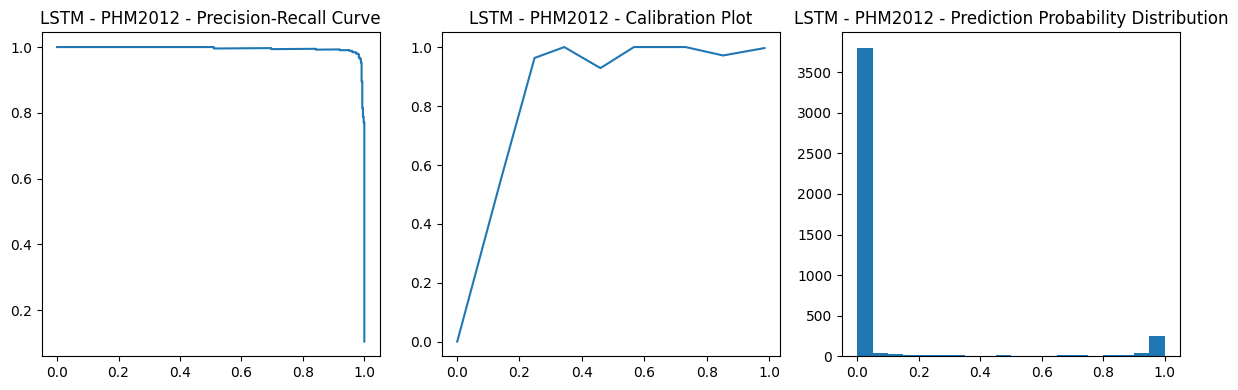

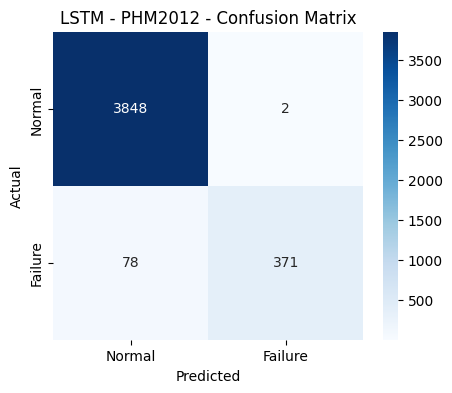

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

GRU - PHM2012 Results:
Accuracy=0.9949, Precision=0.9651, Recall=0.9866, F1=0.9758, ROC-AUC=0.9996, PR-AUC=0.9964


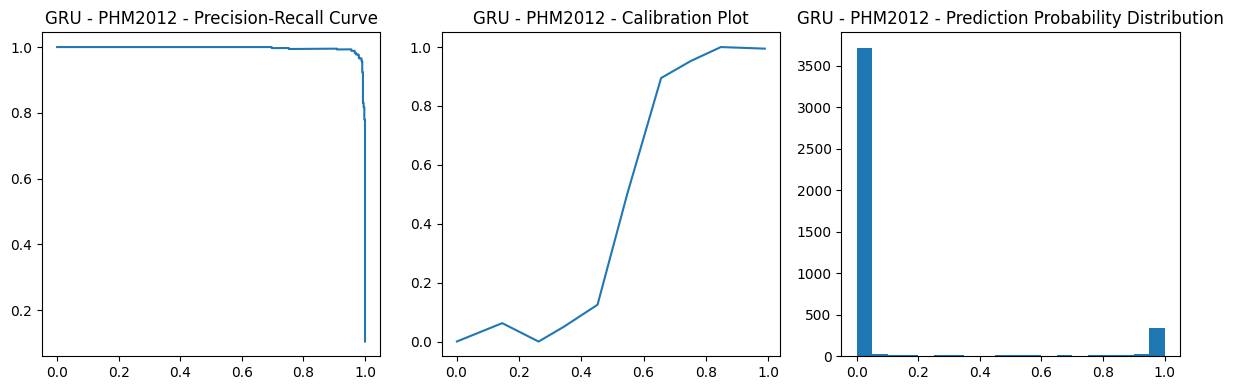

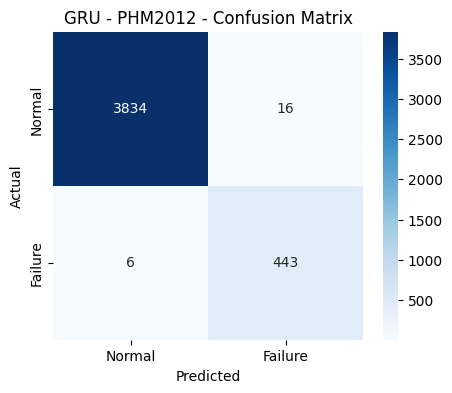

In [48]:
# Evaluate both models
lstm_metrics_phm = maintenance_evaluate_phm_model(model_lstm_phm, X_test_seq_phm, y_test_phm, "LSTM - PHM2012")
gru_metrics_phm = maintenance_evaluate_phm_model(model_gru_phm, X_test_seq_phm, y_test_phm, "GRU - PHM2012")


TRANSFER LEARNING: AI4I ↔ PHM

[1] Testing AI4I-trained models on PHM dataset (Direct Transfer)

  Testing AI4I LSTM on PHM...
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
    AI4I LSTM -> PHM (Direct Transfer):
    Acc=0.8956, F1=0.0000, Prec=0.0000, Rec=0.0000
    Performance drop from AI4I: 0.1995

  Testing AI4I GRU on PHM...
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
    AI4I GRU -> PHM (Direct Transfer):
    Acc=0.1044, F1=0.1891, Prec=0.1044, Rec=1.0000
    Performance drop from AI4I: 0.0190

[2] Testing PHM-trained models on AI4I dataset (Direct Transfer)

  Testing PHM LSTM on AI4I...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
    PHM LSTM -> AI4I (Direct Transfer):
    Acc=0.0350, F1=0.0659, Prec=0.0341, Rec=1.0000
    Performance drop from PHM: 0.8368

  Testing PHM GRU on AI4I...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
    PHM GRU -> AI4I (Direct Transfer):
    Acc=0.9660, F1=0.0000, Prec=0.0000, Rec=0.0000
    Performance drop from PHM: 0.9758

TRANSFER LEARNING RESULTS TABLE
Source

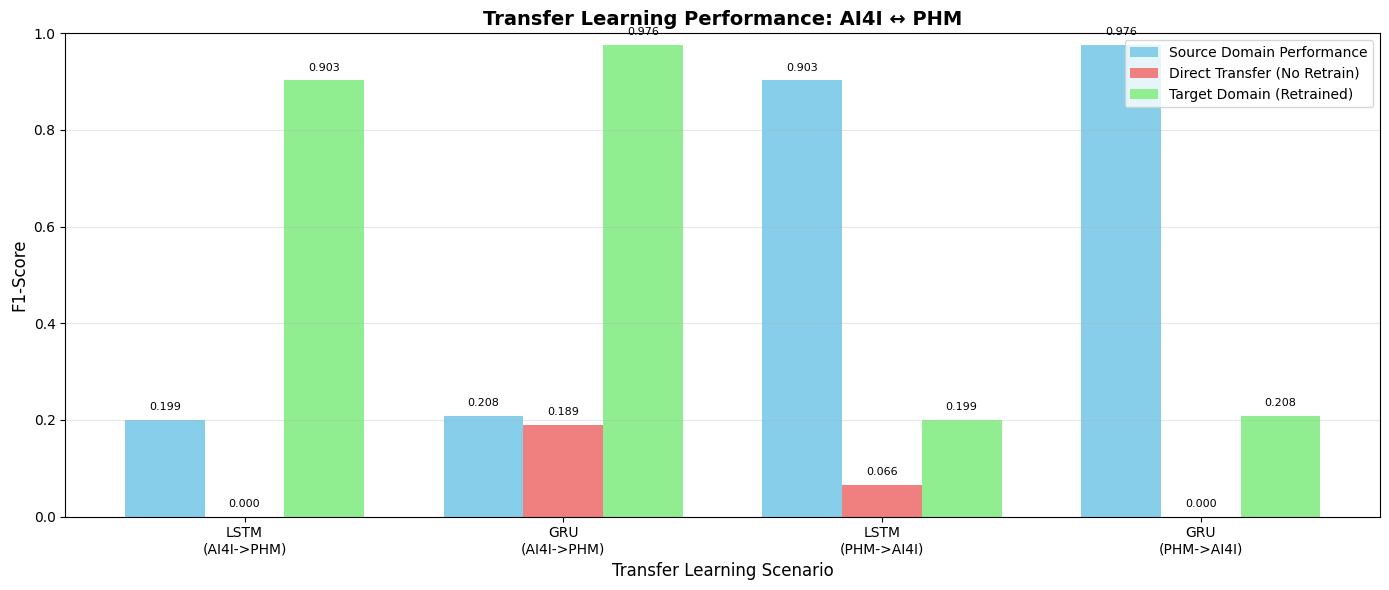


 Transfer Learning Evaluation Complete


In [49]:
# ================================================================================================
# TRANSFER LEARNING EVALUATION: AI4I <-> PHM
# ================================================================================================

print("\n" + "="*100)
print("TRANSFER LEARNING: AI4I ↔ PHM")
print("="*100)

# ---------- AI4I -> PHM Transfer (Direct Transfer - No Retraining) ----------
print("\n[1] Testing AI4I-trained models on PHM dataset (Direct Transfer)")

# Test AI4I LSTM on PHM
print("\n  Testing AI4I LSTM on PHM...")
y_pred_ai4i_lstm_on_phm = model_lstm.predict(X_test_seq_phm).ravel()
y_pred_ai4i_lstm_on_phm_class = (y_pred_ai4i_lstm_on_phm > 0.5).astype(int)

transfer_ai4i_lstm_phm_acc = accuracy_score(y_test_phm, y_pred_ai4i_lstm_on_phm_class)
transfer_ai4i_lstm_phm_f1 = f1_score(y_test_phm, y_pred_ai4i_lstm_on_phm_class, zero_division=0)
transfer_ai4i_lstm_phm_prec = precision_score(y_test_phm, y_pred_ai4i_lstm_on_phm_class, zero_division=0)
transfer_ai4i_lstm_phm_rec = recall_score(y_test_phm, y_pred_ai4i_lstm_on_phm_class, zero_division=0)

print(f"    AI4I LSTM -> PHM (Direct Transfer):")
print(f"    Acc={transfer_ai4i_lstm_phm_acc:.4f}, F1={transfer_ai4i_lstm_phm_f1:.4f}, Prec={transfer_ai4i_lstm_phm_prec:.4f}, Rec={transfer_ai4i_lstm_phm_rec:.4f}")
print(f"    Performance drop from AI4I: {(lstm_f1 - transfer_ai4i_lstm_phm_f1):.4f}")

# Test AI4I GRU on PHM
print("\n  Testing AI4I GRU on PHM...")
y_pred_ai4i_gru_on_phm = model_gru.predict(X_test_seq_phm).ravel()
y_pred_ai4i_gru_on_phm_class = (y_pred_ai4i_gru_on_phm > 0.5).astype(int)

transfer_ai4i_gru_phm_acc = accuracy_score(y_test_phm, y_pred_ai4i_gru_on_phm_class)
transfer_ai4i_gru_phm_f1 = f1_score(y_test_phm, y_pred_ai4i_gru_on_phm_class, zero_division=0)
transfer_ai4i_gru_phm_prec = precision_score(y_test_phm, y_pred_ai4i_gru_on_phm_class, zero_division=0)
transfer_ai4i_gru_phm_rec = recall_score(y_test_phm, y_pred_ai4i_gru_on_phm_class, zero_division=0)

print(f"    AI4I GRU -> PHM (Direct Transfer):")
print(f"    Acc={transfer_ai4i_gru_phm_acc:.4f}, F1={transfer_ai4i_gru_phm_f1:.4f}, Prec={transfer_ai4i_gru_phm_prec:.4f}, Rec={transfer_ai4i_gru_phm_rec:.4f}")
print(f"    Performance drop from AI4I: {(gru_f1 - transfer_ai4i_gru_phm_f1):.4f}")


# ---------- PHM -> AI4I Transfer (Direct Transfer - No Retraining) ----------
print("\n[2] Testing PHM-trained models on AI4I dataset (Direct Transfer)")

# Test PHM LSTM on AI4I
print("\n  Testing PHM LSTM on AI4I...")
y_pred_phm_lstm_on_ai4i = model_lstm_phm.predict(X_test_seq).ravel()
y_pred_phm_lstm_on_ai4i_class = (y_pred_phm_lstm_on_ai4i > 0.5).astype(int)

transfer_phm_lstm_ai4i_acc = accuracy_score(y_test_seq, y_pred_phm_lstm_on_ai4i_class)
transfer_phm_lstm_ai4i_f1 = f1_score(y_test_seq, y_pred_phm_lstm_on_ai4i_class, zero_division=0)
transfer_phm_lstm_ai4i_prec = precision_score(y_test_seq, y_pred_phm_lstm_on_ai4i_class, zero_division=0)
transfer_phm_lstm_ai4i_rec = recall_score(y_test_seq, y_pred_phm_lstm_on_ai4i_class, zero_division=0)

print(f"    PHM LSTM -> AI4I (Direct Transfer):")
print(f"    Acc={transfer_phm_lstm_ai4i_acc:.4f}, F1={transfer_phm_lstm_ai4i_f1:.4f}, Prec={transfer_phm_lstm_ai4i_prec:.4f}, Rec={transfer_phm_lstm_ai4i_rec:.4f}")
print(f"    Performance drop from PHM: {(lstm_metrics_phm[3] - transfer_phm_lstm_ai4i_f1):.4f}")

# Test PHM GRU on AI4I
print("\n  Testing PHM GRU on AI4I...")
y_pred_phm_gru_on_ai4i = model_gru_phm.predict(X_test_seq).ravel()
y_pred_phm_gru_on_ai4i_class = (y_pred_phm_gru_on_ai4i > 0.5).astype(int)

transfer_phm_gru_ai4i_acc = accuracy_score(y_test_seq, y_pred_phm_gru_on_ai4i_class)
transfer_phm_gru_ai4i_f1 = f1_score(y_test_seq, y_pred_phm_gru_on_ai4i_class, zero_division=0)
transfer_phm_gru_ai4i_prec = precision_score(y_test_seq, y_pred_phm_gru_on_ai4i_class, zero_division=0)
transfer_phm_gru_ai4i_rec = recall_score(y_test_seq, y_pred_phm_gru_on_ai4i_class, zero_division=0)

print(f"    PHM GRU -> AI4I (Direct Transfer):")
print(f"    Acc={transfer_phm_gru_ai4i_acc:.4f}, F1={transfer_phm_gru_ai4i_f1:.4f}, Prec={transfer_phm_gru_ai4i_prec:.4f}, Rec={transfer_phm_gru_ai4i_rec:.4f}")
print(f"    Performance drop from PHM: {(gru_metrics_phm[3] - transfer_phm_gru_ai4i_f1):.4f}")


# ---------- Transfer Learning Results Table ----------
print("\n" + "="*100)
print("TRANSFER LEARNING RESULTS TABLE")
print("="*100)

transfer_results = {
    'Source': ['AI4I', 'AI4I', 'PHM', 'PHM'],
    'Target': ['PHM', 'PHM', 'AI4I', 'AI4I'],
    'Model': ['LSTM', 'GRU', 'LSTM', 'GRU'],
    'F1_Source': [lstm_f1, gru_f1, lstm_metrics_phm[3], gru_metrics_phm[3]],
    'F1_DirectTransfer': [transfer_ai4i_lstm_phm_f1, transfer_ai4i_gru_phm_f1,
                          transfer_phm_lstm_ai4i_f1, transfer_phm_gru_ai4i_f1],
    'F1_Retrained': [lstm_metrics_phm[3], gru_metrics_phm[3], lstm_f1, gru_f1],
    'TransferGap': [
        (lstm_f1 - transfer_ai4i_lstm_phm_f1),
        (gru_f1 - transfer_ai4i_gru_phm_f1),
        (lstm_metrics_phm[3] - transfer_phm_lstm_ai4i_f1),
        (gru_metrics_phm[3] - transfer_phm_gru_ai4i_f1)
    ],
    'RetrainingGain': [
        (lstm_metrics_phm[3] - transfer_ai4i_lstm_phm_f1),
        (gru_metrics_phm[3] - transfer_ai4i_gru_phm_f1),
        (lstm_f1 - transfer_phm_lstm_ai4i_f1),
        (gru_f1 - transfer_phm_gru_ai4i_f1)
    ]
}

df_transfer = maintenance_pd.DataFrame(transfer_results)
print(df_transfer.round(4).to_string(index=False))


# ---------- Transfer Learning Visualization ----------
plt.figure(figsize=(14, 6))

models_transfer = ['LSTM\n(AI4I->PHM)', 'GRU\n(AI4I->PHM)', 'LSTM\n(PHM->AI4I)', 'GRU\n(PHM->AI4I)']
x = maintenance_np.arange(len(models_transfer))
width = 0.25

source_scores = [lstm_f1, gru_f1, lstm_metrics_phm[3], gru_metrics_phm[3]]
transfer_scores = [transfer_ai4i_lstm_phm_f1, transfer_ai4i_gru_phm_f1,
                   transfer_phm_lstm_ai4i_f1, transfer_phm_gru_ai4i_f1]
retrain_scores = [lstm_metrics_phm[3], gru_metrics_phm[3], lstm_f1, gru_f1]

plt.bar(x - width, source_scores, width, label='Source Domain Performance', color='skyblue')
plt.bar(x, transfer_scores, width, label='Direct Transfer (No Retrain)', color='lightcoral')
plt.bar(x + width, retrain_scores, width, label='Target Domain (Retrained)', color='lightgreen')

plt.xlabel('Transfer Learning Scenario', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('Transfer Learning Performance: AI4I ↔ PHM', fontsize=14, fontweight='bold')
plt.xticks(x, models_transfer, fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, axis='y', alpha=0.3)
plt.ylim(0, 1.0)

# Add value labels
for i in range(len(x)):
    plt.text(i - width, source_scores[i] + 0.02, f'{source_scores[i]:.3f}', ha='center', fontsize=8)
    plt.text(i, transfer_scores[i] + 0.02, f'{transfer_scores[i]:.3f}', ha='center', fontsize=8)
    plt.text(i + width, retrain_scores[i] + 0.02, f'{retrain_scores[i]:.3f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\n Transfer Learning Evaluation Complete")


FAIRNESS AND BIAS EVALUATION

[1] PHM Dataset - Bearing Type Fairness Analysis
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fairness Metrics by Bearing Type:
   Bearing  Count    FPR    FNR    TPR  Accuracy  Disparate_Impact
Bearing2_3    248 0.0096 0.1795 0.8205    0.9637            1.0000
Bearing1_5    458 0.0000 0.3667 0.6333    0.9760            0.7719
Bearing1_2    176 0.0000 0.2778 0.7222    0.9716            0.8802
Bearing1_1    527 0.0000 0.2439 0.7561    0.9810            0.9215
Bearing3_2    326 0.0000 0.0455 0.9545    0.9908            1.1634
Bearing2_1    169 0.0000 0.2000 0.8000    0.9822            0.9750
Bearing2_5    406 0.0000 0.2647 0.7353    0.9778            0.8961
Bearing1_6    447 0.0000 0.3214 0.6786    0.9799            0.8270
Bearing2_6    112 0.0000 0.0370 0.9630    0.9911            1.1736
Bearing1_7    311 0.0000 0.3846 0.6154    0.9839            0.7500
Bearing1_4    246 0.0000 0.2500 0.7500    0.9797            0.9141
Bearing2_7     30 0.0000 0.0000 1.0000  

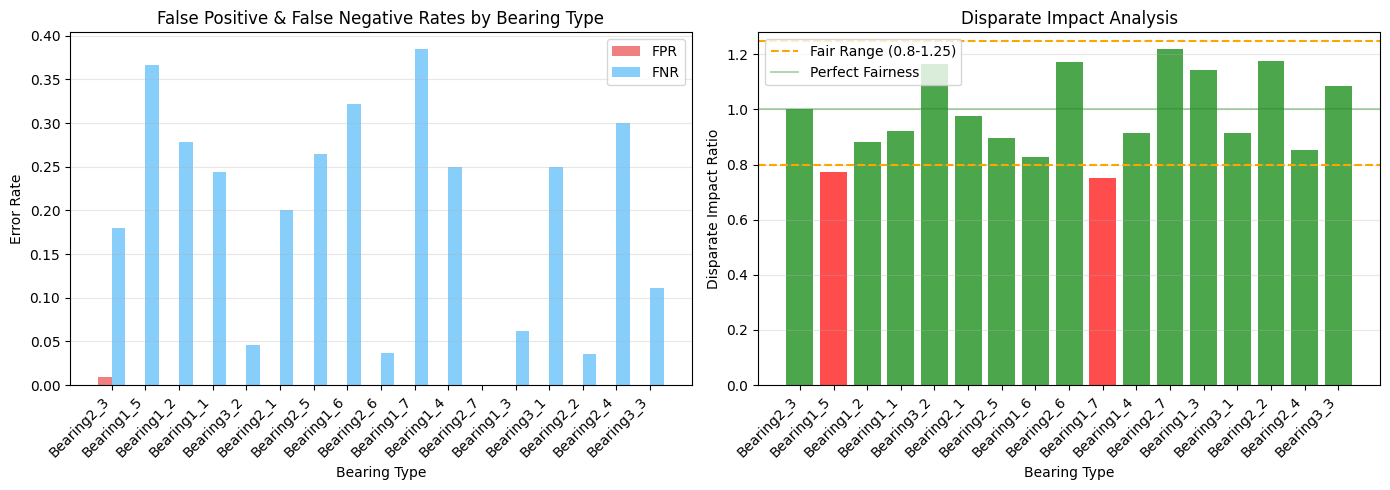

In [50]:
# ================================================================================================
# FAIRNESS AND BIAS EVALUATION (SIMPLIFIED)
# ================================================================================================

print("\n" + "="*100)
print("FAIRNESS AND BIAS EVALUATION")
print("="*100)

# ---------- PHM Dataset: Bearing Type Fairness ----------
print("\n[1] PHM Dataset - Bearing Type Fairness Analysis")

# Get predictions
y_pred_lstm_phm = (model_lstm_phm.predict(X_test_seq_phm).ravel() > 0.5).astype(int)

# Get bearing types for test samples
bearing_types = phm_data.loc[y_test_phm.index, 'Bearing'].reset_index(drop=True)

# Calculate fairness metrics by bearing type
fairness_results = []
for bearing in bearing_types.unique():
    mask = bearing_types == bearing
    y_true_group = y_test_phm.reset_index(drop=True)[mask]
    y_pred_group = y_pred_lstm_phm[mask]

    if len(y_true_group) < 10:  # Skip groups with too few samples
        continue

    # Calculate confusion matrix
    tn = ((y_true_group == 0) & (y_pred_group == 0)).sum()
    fp = ((y_true_group == 0) & (y_pred_group == 1)).sum()
    fn = ((y_true_group == 1) & (y_pred_group == 0)).sum()
    tp = ((y_true_group == 1) & (y_pred_group == 1)).sum()

    # Calculate rates
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0

    fairness_results.append({
        'Bearing': bearing,
        'Count': len(y_true_group),
        'FPR': fpr,
        'FNR': fnr,
        'TPR': tpr,
        'Accuracy': (tp + tn) / len(y_true_group)
    })

fairness_df = maintenance_pd.DataFrame(fairness_results)

# Calculate Disparate Impact
reference_tpr = fairness_df.iloc[0]['TPR']
fairness_df['Disparate_Impact'] = fairness_df['TPR'] / reference_tpr

print("\nFairness Metrics by Bearing Type:")
print(fairness_df.round(4).to_string(index=False))

# Check if fair (0.8 to 1.25 is acceptable)
print("\nFairness Assessment:")
for idx, row in fairness_df.iterrows():
    di = row['Disparate_Impact']
    status = "✓ FAIR" if 0.8 <= di <= 1.25 else "✗ BIAS DETECTED"
    print(f"  {row['Bearing']}: Disparate Impact = {di:.3f} - {status}")

# Visualization
plt.figure(figsize=(14, 5))

# Plot 1: FPR and FNR by Bearing
plt.subplot(1, 2, 1)
x_pos = maintenance_np.arange(len(fairness_df))
plt.bar(x_pos - 0.2, fairness_df['FPR'], 0.4, label='FPR', color='lightcoral')
plt.bar(x_pos + 0.2, fairness_df['FNR'], 0.4, label='FNR', color='lightskyblue')
plt.xticks(x_pos, fairness_df['Bearing'], rotation=45, ha='right')
plt.xlabel('Bearing Type')
plt.ylabel('Error Rate')
plt.title('False Positive & False Negative Rates by Bearing Type')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Plot 2: Disparate Impact
plt.subplot(1, 2, 2)
colors = ['green' if 0.8 <= x <= 1.25 else 'red' for x in fairness_df['Disparate_Impact']]
plt.bar(range(len(fairness_df)), fairness_df['Disparate_Impact'], color=colors, alpha=0.7)
plt.axhline(y=0.8, color='orange', linestyle='--', label='Fair Range (0.8-1.25)')
plt.axhline(y=1.25, color='orange', linestyle='--')
plt.axhline(y=1.0, color='green', linestyle='-', alpha=0.3, label='Perfect Fairness')
plt.xticks(range(len(fairness_df)), fairness_df['Bearing'], rotation=45, ha='right')
plt.xlabel('Bearing Type')
plt.ylabel('Disparate Impact Ratio')
plt.title('Disparate Impact Analysis')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [51]:
# ================================================================================================
# STATISTICAL VALIDATION (SIMPLIFIED)
# ================================================================================================

print("\n" + "="*100)
print("STATISTICAL VALIDATION")
print("="*100)

from scipy.stats import wilcoxon
from sklearn.utils import resample

# ---------- 1. Wilcoxon Test: LSTM vs GRU (AI4I) ----------
print("\n[1] Wilcoxon Signed-Rank Test: LSTM vs GRU (AI4I Dataset)")

# Get predictions
lstm_preds_ai4i = model_lstm.predict(X_test_seq).ravel()
gru_preds_ai4i = model_gru.predict(X_test_seq).ravel()

# Calculate errors
lstm_errors = maintenance_np.abs(y_test_seq - ((lstm_preds_ai4i > 0.5).astype(int)))
gru_errors = maintenance_np.abs(y_test_seq - ((gru_preds_ai4i > 0.5).astype(int)))

# Perform test
statistic_ai4i, p_value_ai4i = wilcoxon(lstm_errors, gru_errors)

print(f"\nResults:")
print(f"  Statistic: {statistic_ai4i:.4f}")
print(f"  p-value: {p_value_ai4i:.4f}")
print(f"  Conclusion: {'LSTM and GRU perform significantly differently (p<0.05)' if p_value_ai4i < 0.05 else 'No significant difference between LSTM and GRU (p≥0.05)'}")


# ---------- 2. Wilcoxon Test: LSTM vs GRU (PHM) ----------
print("\n[2] Wilcoxon Signed-Rank Test: LSTM vs GRU (PHM Dataset)")

# Get predictions
lstm_preds_phm = model_lstm_phm.predict(X_test_seq_phm).ravel()
gru_preds_phm = model_gru_phm.predict(X_test_seq_phm).ravel()

# Calculate errors
lstm_errors_phm = maintenance_np.abs(y_test_phm.values - ((lstm_preds_phm > 0.5).astype(int)))
gru_errors_phm = maintenance_np.abs(y_test_phm.values - ((gru_preds_phm > 0.5).astype(int)))

# Perform test
statistic_phm, p_value_phm = wilcoxon(lstm_errors_phm, gru_errors_phm)

print(f"\nResults:")
print(f"  Statistic: {statistic_phm:.4f}")
print(f"  p-value: {p_value_phm:.4f}")
print(f"  Conclusion: {'LSTM and GRU perform significantly differently (p<0.05)' if p_value_phm < 0.05 else 'No significant difference between LSTM and GRU (p≥0.05)'}")


STATISTICAL VALIDATION

[1] Wilcoxon Signed-Rank Test: LSTM vs GRU (AI4I Dataset)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Results:
  Statistic: 68000.0000
  p-value: 0.0000
  Conclusion: LSTM and GRU perform significantly differently (p<0.05)

[2] Wilcoxon Signed-Rank Test: LSTM vs GRU (PHM Dataset)
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Results:
  Statistic: 609.0000
  p-value: 0.0000
  Conclusion: LSTM and GRU perform significantly differently (p<0.05)



 Bootstrap 95% Confidence Intervals

AI4I Dataset:
  LSTM F1-Score: 0.0656 [95% CI: 0.0507, 0.0816]
  GRU F1-Score:  0.0000 [95% CI: 0.0000, 0.0000]

PHM Dataset:
  LSTM F1-Score: 0.9029 [95% CI: 0.8820, 0.9227]
  GRU F1-Score:  0.9757 [95% CI: 0.9654, 0.9854]

 Effect Size (Cohen's d)

AI4I Dataset - Cohen's d: 5.1412
  Interpretation: Medium to large effect

PHM Dataset - Cohen's d: 0.1249
  Interpretation: Negligible effect (models perform very similarly)

STATISTICAL VALIDATION SUMMARY TABLE
Dataset        Test    Value Interpretation     LSTM_F1_CI      GRU_F1_CI
   AI4I    Wilcoxon p=0.0000    Significant [0.051, 0.082] [0.000, 0.000]
   AI4I Effect Size d=5.1412         Small+              -              -
    PHM    Wilcoxon p=0.0000    Significant [0.882, 0.923] [0.965, 0.985]
    PHM Effect Size d=0.1249     Negligible              -              -


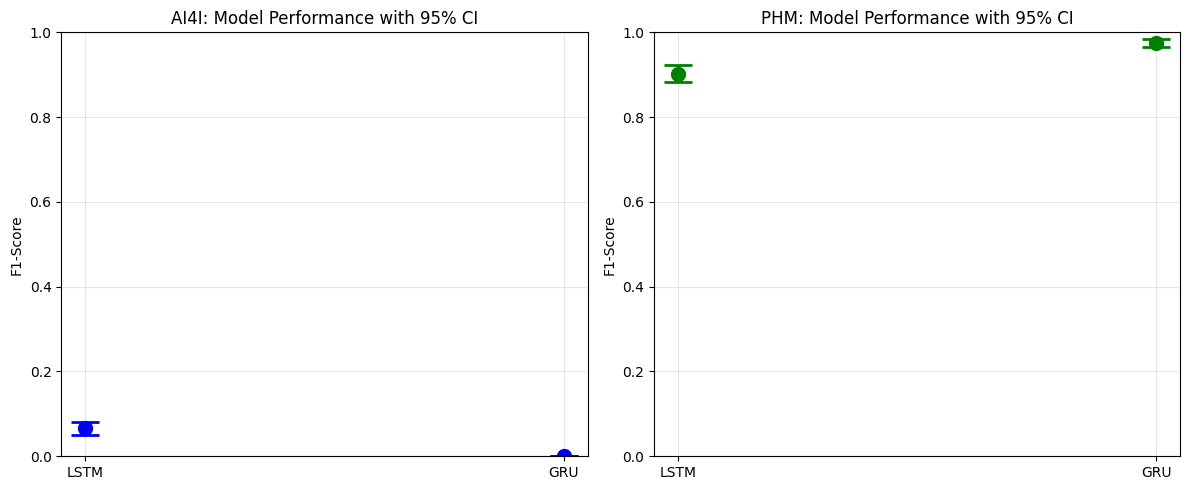


All Statistical Validation Complete


In [52]:
# ---------- Bootstrap Confidence Intervals ----------
print("\n Bootstrap 95% Confidence Intervals")

def bootstrap_ci(y_true, y_pred_proba, metric_func, n_iter=1000):
    """Calculate bootstrap CI"""
    scores = []
    for i in range(n_iter):
        indices = resample(range(len(y_true)), n_samples=len(y_true))
        y_boot = y_true[indices]
        pred_boot = y_pred_proba[indices]
        score = metric_func(y_boot, (pred_boot > 0.5).astype(int))
        scores.append(score)

    lower = maintenance_np.percentile(scores, 2.5)
    upper = maintenance_np.percentile(scores, 97.5)
    mean = maintenance_np.mean(scores)
    return mean, lower, upper

# AI4I Dataset
print("\nAI4I Dataset:")
lstm_f1_mean, lstm_f1_low, lstm_f1_high = bootstrap_ci(y_test_seq, lstm_preds_ai4i, f1_score)
gru_f1_mean, gru_f1_low, gru_f1_high = bootstrap_ci(y_test_seq, gru_preds_ai4i, f1_score)

print(f"  LSTM F1-Score: {lstm_f1_mean:.4f} [95% CI: {lstm_f1_low:.4f}, {lstm_f1_high:.4f}]")
print(f"  GRU F1-Score:  {gru_f1_mean:.4f} [95% CI: {gru_f1_low:.4f}, {gru_f1_high:.4f}]")

# PHM Dataset
print("\nPHM Dataset:")
lstm_f1_mean_phm, lstm_f1_low_phm, lstm_f1_high_phm = bootstrap_ci(y_test_phm.values, lstm_preds_phm, f1_score)
gru_f1_mean_phm, gru_f1_low_phm, gru_f1_high_phm = bootstrap_ci(y_test_phm.values, gru_preds_phm, f1_score)

print(f"  LSTM F1-Score: {lstm_f1_mean_phm:.4f} [95% CI: {lstm_f1_low_phm:.4f}, {lstm_f1_high_phm:.4f}]")
print(f"  GRU F1-Score:  {gru_f1_mean_phm:.4f} [95% CI: {gru_f1_low_phm:.4f}, {gru_f1_high_phm:.4f}]")


# ---------- Effect Size ----------
print("\n Effect Size (Cohen's d)")

def cohens_d(group1, group2):
    """Calculate Cohen's d"""
    mean_diff = maintenance_np.mean(group1) - maintenance_np.mean(group2)
    pooled_std = maintenance_np.sqrt((maintenance_np.var(group1) + maintenance_np.var(group2)) / 2)
    return mean_diff / pooled_std if pooled_std > 0 else 0

effect_size_ai4i = cohens_d(lstm_errors, gru_errors)
effect_size_phm = cohens_d(lstm_errors_phm, gru_errors_phm)

print(f"\nAI4I Dataset - Cohen's d: {effect_size_ai4i:.4f}")
if abs(effect_size_ai4i) < 0.2:
    print("  Interpretation: Negligible effect (models perform very similarly)")
elif abs(effect_size_ai4i) < 0.5:
    print("  Interpretation: Small effect")
else:
    print("  Interpretation: Medium to large effect")

print(f"\nPHM Dataset - Cohen's d: {effect_size_phm:.4f}")
if abs(effect_size_phm) < 0.2:
    print("  Interpretation: Negligible effect (models perform very similarly)")
elif abs(effect_size_phm) < 0.5:
    print("  Interpretation: Small effect")
else:
    print("  Interpretation: Medium to large effect")


# ---------- Summary Table ----------
print("\n" + "="*100)
print("STATISTICAL VALIDATION SUMMARY TABLE")
print("="*100)

stat_summary = {
    'Dataset': ['AI4I', 'AI4I', 'PHM', 'PHM'],
    'Test': ['Wilcoxon', 'Effect Size', 'Wilcoxon', 'Effect Size'],
    'Value': [
        f'p={p_value_ai4i:.4f}',
        f'd={effect_size_ai4i:.4f}',
        f'p={p_value_phm:.4f}',
        f'd={effect_size_phm:.4f}'
    ],
    'Interpretation': [
        'Significant' if p_value_ai4i < 0.05 else 'Not significant',
        'Negligible' if abs(effect_size_ai4i) < 0.2 else 'Small+',
        'Significant' if p_value_phm < 0.05 else 'Not significant',
        'Negligible' if abs(effect_size_phm) < 0.2 else 'Small+'
    ],
    'LSTM_F1_CI': [
        f'[{lstm_f1_low:.3f}, {lstm_f1_high:.3f}]',
        '-',
        f'[{lstm_f1_low_phm:.3f}, {lstm_f1_high_phm:.3f}]',
        '-'
    ],
    'GRU_F1_CI': [
        f'[{gru_f1_low:.3f}, {gru_f1_high:.3f}]',
        '-',
        f'[{gru_f1_low_phm:.3f}, {gru_f1_high_phm:.3f}]',
        '-'
    ]
}

stat_df = maintenance_pd.DataFrame(stat_summary)
print(stat_df.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 5))

# Plot 1: AI4I Confidence Intervals
plt.subplot(1, 2, 1)
models = ['LSTM', 'GRU']
f1_means = [lstm_f1_mean, gru_f1_mean]
f1_errs = [[lstm_f1_mean - lstm_f1_low, gru_f1_mean - gru_f1_low],
           [lstm_f1_high - lstm_f1_mean, gru_f1_high - gru_f1_mean]]
plt.errorbar(models, f1_means, yerr=f1_errs, fmt='o', markersize=10,
             capsize=10, capthick=2, linewidth=2, color='blue')
plt.ylabel('F1-Score')
plt.title('AI4I: Model Performance with 95% CI')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Plot 2: PHM Confidence Intervals
plt.subplot(1, 2, 2)
f1_means_phm = [lstm_f1_mean_phm, gru_f1_mean_phm]
f1_errs_phm = [[lstm_f1_mean_phm - lstm_f1_low_phm, gru_f1_mean_phm - gru_f1_low_phm],
               [lstm_f1_high_phm - lstm_f1_mean_phm, gru_f1_high_phm - gru_f1_mean_phm]]
plt.errorbar(models, f1_means_phm, yerr=f1_errs_phm, fmt='o', markersize=10,
             capsize=10, capthick=2, linewidth=2, color='green')
plt.ylabel('F1-Score')
plt.title('PHM: Model Performance with 95% CI')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

print("\nAll Statistical Validation Complete")